In [1]:
cd ~/code/jwstmc/


/home/lnie/code/jwstmc


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
import os
import time
import webbpsf
nrca_short_filters = ['F070W', 'F090W', 'F115W', 'F140M', 'F150W2', 'F150W', 'F162M', 'F164N', 'F182M', 'F187N',
                          'F200W', 'F210M', 'F212N']
nrca_long_filters = ['F250M', 'F277W', 'F300M', 'F322W2', 'F323N', 'F335M', 'F356W', 'F360M', 'F405N', 'F410M',
                         'F430M', 'F444W', 'F460M', 'F466N', 'F470N', 'F480M']

nrca_short_detectors = ['NRCA1', 'NRCA2', 'NRCA3', 'NRCA4', 'NRCB1', 'NRCB2', 'NRCB3', 'NRCB4']
nrca_long_detectors = ['NRCA5', 'NRCB5']
F090W_fname="jw02736001001_02101_"
F150W_fname="jw02736001001_02103_"
F200W_fname="jw02736001001_02105_"
F277W_fname="jw02736001001_02101_"
F356W_fname="jw02736001001_02103_"
F444W_fname="jw02736001001_02105_"
sdetect=["nrca1","nrca2","nrca3","nrca4","nrcb1","nrcb2","nrcb3","nrcb4"]
ldetect=["nrcalong","nrcblong"]
detector=dict({"nrca1":"nrca1","nrca2":"nrca2","nrca3":"nrca3","nrca4":"nrca4",
               "nrcb1":"nrcb1","nrcb2":"nrcb2","nrcb3":"nrcb3","nrcb4":"nrcb4",
               "nrcalong":"nrca5","nrcblong":"nrcb5"})
filte_name=dict({"F090W":"jw02736001001_02101_","F150W":"jw02736001001_02103_",
                "F200W":"jw02736001001_02105_","F277W":"jw02736001001_02101_",
                "F356W":"jw02736001001_02103_","F444W":"jw02736001001_02105_"})
f2detpath=dict({"F090W":sdetect,"F150W":sdetect,"F200W":sdetect,
                "F277W":ldetect,"F356W":ldetect,"F444W":ldetect})
gains=dict({"nrca1":"2.08","nrca2":"2.02","nrca3":"2.17","nrca4":"2.02",
            "nrcb1":"2.01","nrcb2":"2.14","nrcb3":"1.94","nrcb4":"2.03",
            "nrcalong":"1.84","nrcblong":"1.80"})


In [5]:
dirs="/data/JWST_rev/"
Cam="NIRCam/"
afiltes=['F277W', 'F356W', 'F444W', 'F200W', 'F150W', 'F090W']
bfiltes=['F277W', 'F356W', 'F444W', 'F200W', 'F150W', 'F090W']
fileds=["parallel_field","cluster_field"]
fileds=dict({"parallel_field":afiltes,
              "cluster_field":bfiltes})
para_appends=dict({'F277W':"along_it0_UPDC_rev4", 
                   'F356W':"along_it0_UPDC_rev4", 
                   'F444W':"along_it0_UPDC_rev4", 
                   'F200W':"a_it0_UPDC_rev4.fits",
                   'F150W':"a_it0_UPDC_rev4.fits",
                   'F090W':"a_it0_UPDC_rev4.fits"})
clus_appends=dict({'F277W':"blong_it0_UPDC_rev4", 
                   'F356W':"blong_it0_UPDC_rev4", 
                   'F444W':"blong_it0_UPDC_rev4", 
                   'F200W':"b_it0_UPDC_rev4.fits",
                   'F150W':"b_it0_UPDC_rev4.fits",
                   'F090W':"b_it0_UPDC_rev4.fits"})
cat_header=["#   1 NUMBER                 Running object number\n",                                  
"#   2 X_IMAGE                Object position along x                                      [pixel]\n",
"#   3 Y_IMAGE                Object position along y                                      [pixel]\n",
"#   4 FWHM_IMAGE             FWHM assuming a gaussian core                                [pixel]\n",
"#   5 FLUX_RADIUS            Fraction-of-light radii                                      [pixel]\n",
"#   6 FLUX_AUTO              Flux within a Kron-like elliptical aperture                  [count]\n",
"#   7 FLUXERR_AUTO           RMS error for AUTO flux                                      [count]\n",
"#   8 FLAGS                  Extraction flags                                                    \n"                                          
"#   9 CLASS_STAR             S/G classifier output\n"]

#defination useful functions
def get_filename(file_dir,append):
    fname=[];
    for list in os.listdir(file_dir):
        if os.path.isfile(os.path.join(file_dir,list)):
            if list[(len(list)-len(append)):len(list)]==append:
                fname.append(list);

    return fname
def write_fits(fitsname,data,head1=None,head2=None):
    wdata=data;
    if head1==None :
        #print("head1 none",fitsname)
        hdu = fits.PrimaryHDU(wdata)
        hdul = fits.HDUList([hdu])
        hdul.writeto(fitsname,overwrite=True)
    if head1!=None and head1==None:
        #print("head2 none",fitsname)
        hdu = fits.PrimaryHDU(wdata,header=head1)
        hdul = fits.HDUList([hdu])
        hdul.writeto(fitsname,overwrite=True)
    if head1!=None and head2!=None:
        #print("head1 not none",fitsname)
        hdu = fits.PrimaryHDU(header=head1)
        hdu1= fits.ImageHDU(wdata,header=head2)
        hdul = fits.HDUList([hdu,hdu1])
        hdul.writeto(fitsname,overwrite=True)
def fft_conv(image,psf):
    '''
    convlove image with a psf,usually image size should be larger than psf
    '''
    size=image.shape
    core=np.zeros(size,dtype='float')
    nx=image.shape[0];ny=image.shape[1]
    px=psf.shape[0];py=psf.shape[1]
    ra=int((nx-px)/2);rb=int((ny-py)/2)
    core[ra-1:ra+px-1,rb-1:rb+py-1]=psf
    Fg=np.fft.fft2(image)
    Fp=np.fft.fft2(core)
    Fg*=Fp
    for i in range(Fp.real.shape[0]):
        for j in range(Fp.real.shape[1]):
            l=(i+j+2)%2
            if (l==1) :Fg.real[i][j]*=-1;Fg.imag[i][j]*=-1;
    tmp=np.fft.ifft2(Fg)
    cimage=tmp.real
    return(cimage)

def pixel2wcs(header,px,py):
    CD1_1   =  header['CD1_1']
    CD1_2   =  header['CD1_2']
    CD2_1   =  header['CD2_1']
    CD2_2   =  header['CD2_2'] 
    CRPIX1  =  header['CRPIX1']
    CRPIX2  =  header['CRPIX2']  
    CRVAL1  =  header['CRVAL1']
    CRVAL2  =  header['CRVAL2'] 
    MCD=np.array([[CD1_1,CD1_2],
                  [CD2_1,CD2_2]])
    Mp=np.array([px-CRPIX1,py-CRPIX2])
    Mt=np.matmul(MCD,Mp)
    Mwcs=np.array([CRVAL1,CRVAL2])
    Mwcs=Mt+Mwcs
    return(Mwcs[0],Mwcs[1])

def wcs2pixel(header,wcsx,wcsy):
    CD1_1   =  header['CD1_1']
    CD1_2   =  header['CD1_2']
    CD2_1   =  header['CD2_1']
    CD2_2   =  header['CD2_2'] 
    CRPIX1  =  header['CRPIX1']
    CRPIX2  =  header['CRPIX2']  
    CRVAL1  =  header['CRVAL1']
    CRVAL2  =  header['CRVAL2'] 
    MCD=np.array([[CD1_1,CD1_2],
                  [CD2_1,CD2_2]])
    Mp=np.array([wcsx-CRVAL1,wcsy-CRVAL2])
    iMCD=np.linalg.inv(MCD)
    Mt=np.matmul(iMCD,Mp)
    Mpos=np.array([CRPIX1,CRPIX2])
    Mpos=Mt+Mpos
    return(Mpos[0],Mpos[1])


fname: /data/JWST_rev/coadd_img/rev4/parallel_field/F277Walong_it0_UPDC_rev4.fits
/home/lnie/data/JWST_rev/NIRCam/F277W//F277Walong_it0_UPDC_rev4.cat


> 
----- Source Extractor 2.25.0 started on 2023-06-01 at 17:00:03 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for F277Walong_it0_UPDC_rev4.fits
----- Measuring from: F277Walong_it0_UPDC_rev4.fits
      "Unnamed" / no ext. header / 4772x4772 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  100
> Setting up background map at line:  200
> Setting up background map at line:  300
> Setting up background map at line:  400
> Setting up background map at line:  500
> Setting up background map at line:  600
> Setting up background map at line:  700
> Setting up background map at line:  800
> Setting up background map at line:  900
> Setting up background map at line: 1000
> Setting up background map at line: 1100
> Setting up background map at line: 1200
> Setting up background 

> Line: 1675  Objects:     9198 detected /     2302 sextracted
> Line: 1700  Objects:     9308 detected /     2354 sextracted

> WARNING: Pixel stack overflow at position 2686,1711

> Line: 1720  Objects:     9388 detected /     2400 sextracted
> Line: 1725  Objects:     9421 detected /     2419 sextracted
> Line: 1750  Objects:     9512 detected /     2490 sextracted
> Line: 1775  Objects:     9645 detected /     2566 sextracted
> Line: 1800  Objects:     9771 detected /     2638 sextracted
> Line: 1825  Objects:     9903 detected /     2680 sextracted
> Line: 1850  Objects:    10035 detected /     2731 sextracted
> Line: 1874  Objects:    10137 detected /     2800 sextracted
> Line: 1875  Objects:    10140 detected /     2804 sextracted
> Line: 1900  Objects:    10259 detected /     2874 sextracted
> Line: 1925  Objects:    10370 detected /     2929 sextracted
> Line: 1950  Objects:    10473 detected /     2990 sextracted
> Line: 1975  Objects:    10606 detected /     3059 sextracted

> Line: 4150  Objects:    21373 detected /     8524 sextracted
> Line: 4175  Objects:    21488 detected /     8602 sextracted
> Line: 4200  Objects:    21603 detected /     8677 sextracted
> Line: 4225  Objects:    21711 detected /     8761 sextracted
> Line: 4239  Objects:    21768 detected /     8800 sextracted
> Line: 4250  Objects:    21803 detected /     8833 sextracted
> Line: 4275  Objects:    21890 detected /     8912 sextracted
> Line: 4300  Objects:    22023 detected /     8988 sextracted
> Line: 4325  Objects:    22162 detected /     9055 sextracted
> Line: 4350  Objects:    22332 detected /     9106 sextracted
> Line: 4375  Objects:    22569 detected /     9175 sextracted
> Line: 4384  Objects:    22648 detected /     9200 sextracted
> Line: 4400  Objects:    22802 detected /     9251 sextracted
> Line: 4425  Objects:    23003 detected /     9325 sextracted
> Line: 4450  Objects:    23274 detected /     9404 sextracted
> Line: 4475  Objects:    23484 detected /     9458 sex

fname: /data/JWST_rev/coadd_img/rev4/parallel_field/F356Walong_it0_UPDC_rev4.fits
/home/lnie/data/JWST_rev/NIRCam/F356W//F356Walong_it0_UPDC_rev4.cat


> 
----- Source Extractor 2.25.0 started on 2023-06-01 at 17:00:20 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for F356Walong_it0_UPDC_rev4.fits
----- Measuring from: F356Walong_it0_UPDC_rev4.fits
      "Unnamed" / no ext. header / 4772x4772 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  100
> Setting up background map at line:  200
> Setting up background map at line:  300
> Setting up background map at line:  400
> Setting up background map at line:  500
> Setting up background map at line:  600
> Setting up background map at line:  700
> Setting up background map at line:  800
> Setting up background map at line:  900
> Setting up background map at line: 1000
> Setting up background map at line: 1100
> Setting up background map at line: 1200
> Setting up background 

> Line: 1700  Objects:    10375 detected /     2506 sextracted
> Line: 1725  Objects:    10531 detected /     2567 sextracted
> Line: 1750  Objects:    10639 detected /     2635 sextracted
> Line: 1775  Objects:    10776 detected /     2698 sextracted
> Line: 1800  Objects:    10902 detected /     2775 sextracted
> Line: 1815  Objects:    10974 detected /     2800 sextracted

> WARNING: Pixel stack overflow at position 919,1821

> Line: 1825  Objects:    11034 detected /     2815 sextracted
> Line: 1850  Objects:    11188 detected /     2873 sextracted
> Line: 1875  Objects:    11331 detected /     2953 sextracted
> Line: 1900  Objects:    11474 detected /     3018 sextracted
> Line: 1925  Objects:    11605 detected /     3076 sextracted
> Line: 1950  Objects:    11728 detected /     3136 sextracted
> Line: 1975  Objects:    11840 detected /     3200 sextracted
> Line: 1976  Objects:    11840 detected /     3200 sextracted
> Line: 2000  Objects:    11971 detected /     3276 sextracted


> Line: 4150  Objects:    24416 detected /     9243 sextracted
> Line: 4175  Objects:    24541 detected /     9340 sextracted
> Line: 4200  Objects:    24650 detected /     9413 sextracted
> Line: 4225  Objects:    24744 detected /     9495 sextracted
> Line: 4250  Objects:    24827 detected /     9588 sextracted
> Line: 4253  Objects:    24834 detected /     9600 sextracted
> Line: 4275  Objects:    24919 detected /     9666 sextracted
> Line: 4300  Objects:    25053 detected /     9752 sextracted
> Line: 4325  Objects:    25184 detected /     9835 sextracted
> Line: 4350  Objects:    25340 detected /     9921 sextracted
> Line: 4373  Objects:    25526 detected /    10000 sextracted
> Line: 4375  Objects:    25538 detected /    10011 sextracted
> Line: 4400  Objects:    25716 detected /    10109 sextracted
> Line: 4425  Objects:    25939 detected /    10194 sextracted
> Line: 4450  Objects:    26174 detected /    10260 sextracted
> Line: 4475  Objects:    26424 detected /    10341 sex

fname: /data/JWST_rev/coadd_img/rev4/parallel_field/F444Walong_it0_UPDC_rev4.fits
/home/lnie/data/JWST_rev/NIRCam/F444W//F444Walong_it0_UPDC_rev4.cat


> 
----- Source Extractor 2.25.0 started on 2023-06-01 at 17:00:39 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for F444Walong_it0_UPDC_rev4.fits
----- Measuring from: F444Walong_it0_UPDC_rev4.fits
      "Unnamed" / no ext. header / 4772x4772 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  100
> Setting up background map at line:  200
> Setting up background map at line:  300
> Setting up background map at line:  400
> Setting up background map at line:  500
> Setting up background map at line:  600
> Setting up background map at line:  700
> Setting up background map at line:  800
> Setting up background map at line:  900
> Setting up background map at line: 1000
> Setting up background map at line: 1100
> Setting up background map at line: 1200
> Setting up background 

> Line: 1825  Objects:    13100 detected /     3657 sextracted
> Line: 1850  Objects:    13295 detected /     3744 sextracted
> Line: 1875  Objects:    13459 detected /     3834 sextracted
> Line: 1900  Objects:    13635 detected /     3925 sextracted
> Line: 1925  Objects:    13801 detected /     4013 sextracted

> WARNING: Pixel stack overflow at position 3479,1932

> Line: 1950  Objects:    13972 detected /     4112 sextracted
> Line: 1975  Objects:    14166 detected /     4194 sextracted
> Line: 2000  Objects:    14373 detected /     4277 sextracted
> Line: 2025  Objects:    14592 detected /     4396 sextracted
> Line: 2050  Objects:    14828 detected /     4512 sextracted
> Line: 2075  Objects:    15009 detected /     4612 sextracted
> Line: 2100  Objects:    15204 detected /     4721 sextracted
> Line: 2125  Objects:    15395 detected /     4830 sextracted
> Line: 2150  Objects:    15602 detected /     4889 sextracted
> Line: 2175  Objects:    15801 detected /     5001 sextracted

> Line: 4600  Objects:    34744 detected /    13962 sextracted
> Line: 4625  Objects:    34913 detected /    14074 sextracted
> Line: 4650  Objects:    34935 detected /    14091 sextracted
> Line: 4675  Objects:    34991 detected /    14091 sextracted
> Line: 4700  Objects:    34991 detected /    14091 sextracted
> Line: 4725  Objects:    34991 detected /    14091 sextracted
> Line: 4750  Objects:    34991 detected /    14091 sextracted
> Line: 4772  Objects:    34991 detected /    14400 sextracted
> Line: 4772  Objects:    34991 detected /    14800 sextracted
> Line: 4772  Objects:    34991 detected /    15200 sextracted
> Line: 4772  Objects:    34991 detected /    15600 sextracted
> Line: 4772  Objects:    34991 detected /    16000 sextracted
> Line: 4772  Objects:    34991 detected /    16400 sextracted
> Line: 4772  Objects:    34991 detected /    16800 sextracted
      Objects: detected 34991    / sextracted 16876           

> Closing files
> 
> All done (in 17.9 s: 266.4 lines/

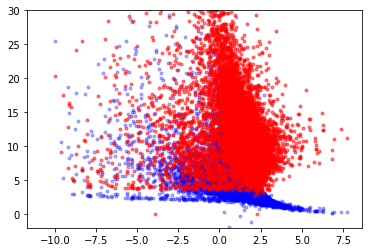

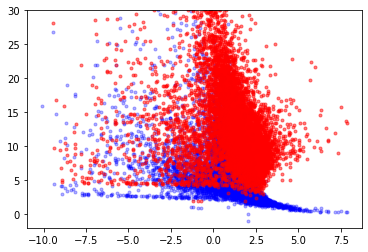

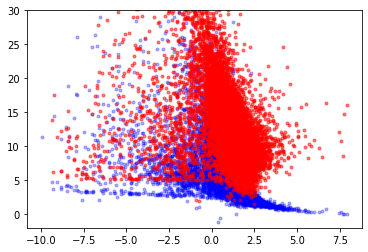

In [38]:
ofdirs="/data/JWST_rev/coadd_img/rev4/"
dirs="/home/lnie/data/JWST_rev/"+Cam
for field in fields:
    fdirs=ofdirs+field+'/'
    for fitle in filtes:
        if 'para' in field:
            slicename=fitle+para_appends[fitle]
        else:
            slicename=fitle+clus_appends[fitle]
        fname=fdirs+slicename+".fits"
        print(fname,)
        hdu=fits.open(fname) 
        data=hdu[0].data
        wdirs=dirs+filte+'/'
        coldcat=wdirs+'/'+slicename+".cat";print(coldcat)
        catcmd=("source-extractor "+fname+" -CATALOG_NAME "+coldcat+" -DETECT_MINAREA 18 \
        -DETECT_THRESH 1.2 -DEBLEND_NTHRESH 64 -DEBLEND_MINCONT 0.04 -BACK_SIZE 100 \
        -BACK_FILTERSIZE 3 -BACKPHOTO_TYPE LOCAL")
        os.system(catcmd)
        cold_cat=np.loadtxt(coldcat)
        r50=cold_cat[:,4];fwhm=cold_cat[:,3];mag=-2.5*np.log10(cold_cat[:,5])
        fig=plt.figure()
        plt.plot(mag,r50,'.',c='blue',alpha=0.3)
        plt.plot(mag,fwhm,'.',c='red',alpha=0.5)
        plt.ylim(-2,30)
        plt.title(slicename+".fits")
        plt.savefig(wdirs+'/'+slicename+'_cat.pdf')


F277W along_it0_UPDC_rev4 F277Walong_it0_UPDC_rev4
fname: /data/JWST_rev/coadd_img/rev4/parallel_field/F277Walong_it0_UPDC_rev4.fits
/home/lnie/data/JWST_rev/NIRCam/F277W//F277Walong_it0_UPDC_rev4.cat
/home/lnie/code/JWSTmc/staridf/cut /home/lnie/data/JWST_rev/NIRCam/F277W/ F277Walong_it0_UPDC_rev4.cat /data/JWST_rev/coadd_img/rev4/parallel_field/ F277Walong_it0_UPDC_rev4.fits /home/lnie/data/JWST_rev/NIRCam/F277W/ -7.5 -0.5. 1.
catalogue:/home/lnie/data/JWST_rev/NIRCam/F277W/F277Walong_it0_UPDC_rev4.cat
fits:/data/JWST_rev/coadd_img/rev4/parallel_field/F277Walong_it0_UPDC_rev4.fits
cata path:/home/lnie/data/JWST_rev/NIRCam/F277W//catalogue
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F277W//catalogue'
slicename=F277Walong_it0_UPDC_rev4
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F277W//catalogue/star_stamps/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F277W//catalogue/star/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F277W//cata

/tmp/ipykernel_2842996/452618057.py:21: RuntimeWarning: invalid value encountered in log10
  r50=cold_cat[:,4];fwhm=cold_cat[:,3];mag=-2.5*np.log10(cold_cat[:,5])


F356W along_it0_UPDC_rev4 F356Walong_it0_UPDC_rev4
fname: /data/JWST_rev/coadd_img/rev4/parallel_field/F356Walong_it0_UPDC_rev4.fits
/home/lnie/data/JWST_rev/NIRCam/F356W//F356Walong_it0_UPDC_rev4.cat
/home/lnie/code/JWSTmc/staridf/cut /home/lnie/data/JWST_rev/NIRCam/F356W/ F356Walong_it0_UPDC_rev4.cat /data/JWST_rev/coadd_img/rev4/parallel_field/ F356Walong_it0_UPDC_rev4.fits /home/lnie/data/JWST_rev/NIRCam/F356W/ -7.5 -0.5. 1.
catalogue:/home/lnie/data/JWST_rev/NIRCam/F356W/F356Walong_it0_UPDC_rev4.cat
fits:/data/JWST_rev/coadd_img/rev4/parallel_field/F356Walong_it0_UPDC_rev4.fits
cata path:/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue'
slicename=F356Walong_it0_UPDC_rev4
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/star_stamps/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/star/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F356W//cata

/tmp/ipykernel_2842996/452618057.py:21: RuntimeWarning: divide by zero encountered in log10
  r50=cold_cat[:,4];fwhm=cold_cat[:,3];mag=-2.5*np.log10(cold_cat[:,5])
/tmp/ipykernel_2842996/452618057.py:21: RuntimeWarning: invalid value encountered in log10
  r50=cold_cat[:,4];fwhm=cold_cat[:,3];mag=-2.5*np.log10(cold_cat[:,5])


F444W along_it0_UPDC_rev4 F444Walong_it0_UPDC_rev4
fname: /data/JWST_rev/coadd_img/rev4/parallel_field/F444Walong_it0_UPDC_rev4.fits
/home/lnie/data/JWST_rev/NIRCam/F444W//F444Walong_it0_UPDC_rev4.cat
/home/lnie/code/JWSTmc/staridf/cut /home/lnie/data/JWST_rev/NIRCam/F444W/ F444Walong_it0_UPDC_rev4.cat /data/JWST_rev/coadd_img/rev4/parallel_field/ F444Walong_it0_UPDC_rev4.fits /home/lnie/data/JWST_rev/NIRCam/F444W/ -7.5 -0.5. 1.
catalogue:/home/lnie/data/JWST_rev/NIRCam/F444W/F444Walong_it0_UPDC_rev4.cat
fits:/data/JWST_rev/coadd_img/rev4/parallel_field/F444Walong_it0_UPDC_rev4.fits
cata path:/home/lnie/data/JWST_rev/NIRCam/F444W//catalogue
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F444W//catalogue'
slicename=F444Walong_it0_UPDC_rev4
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F444W//catalogue/star_stamps/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F444W//catalogue/star/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F444W//cata

/tmp/ipykernel_2842996/452618057.py:21: RuntimeWarning: divide by zero encountered in log10
  r50=cold_cat[:,4];fwhm=cold_cat[:,3];mag=-2.5*np.log10(cold_cat[:,5])
/tmp/ipykernel_2842996/452618057.py:21: RuntimeWarning: invalid value encountered in log10
  r50=cold_cat[:,4];fwhm=cold_cat[:,3];mag=-2.5*np.log10(cold_cat[:,5])


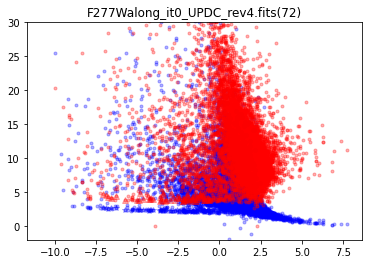

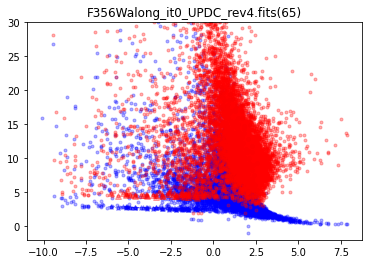

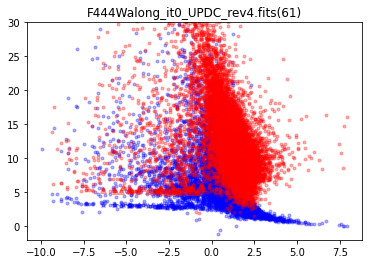

In [45]:
#find star in catalogue
fdirs="/data/JWST_rev/coadd_img/rev4/parallel_field/"
append="along_it0_UPDC_rev4"
dirs="/home/lnie/data/JWST_rev/"+Cam
catdirs="/home/lnie/data/JWST_rev/"+Cam+filte+'/'


ofdirs="/data/JWST_rev/coadd_img/rev4/"
dirs="/home/lnie/data/JWST_rev/"+Cam
for field in fields:
    fdirs=ofdirs+field+'/'
    for fitle in filtes:
        if 'para' in field:
            slicename=fitle+para_appends[fitle]
        else:
            slicename=fitle+clus_appends[fitle]
        fname=fdirs+slicename+".fits"
        wdirs=dirs+filte+'/'
        coldcat=wdirs+'/'+slicename+".cat";print(coldcat)
        if 'long' in slicename:
            staridf=("/home/lnie/code/JWSTmc/staridf/cut "+wdirs+" "
                     +slicename+".cat "+fdirs+" "+slicename+".fits"+" "
                     +wdirs+" -7. -0.5. 1.")
        else:
            staridf=("/home/lnie/code/JWSTmc/staridf/cut "+wdirs+" "
                     +slicename+".cat "+fdirs+" "+slicename+".fits"+" "
                     +wdirs+" -9. -2.. 1.")
        print(staridf)
        os.system(staridf)
        cat=wdirs+slicename+".cat"
        cold_cat=np.loadtxt(cat)
        r50=cold_cat[:,4];fwhm=cold_cat[:,3];mag=-2.5*np.log10(cold_cat[:,5])
        rcat=wdirs+"catalogue/star/"+slicename+"_star"+".cat"
        try:
            rcat=np.loadtxt(rcat);
            rfwhm=rcat[:,3];rmag=-2.5*np.log10(rcat[:,5]);rr50=rcat[:,4];
            fig=plt.figure()
            plt.plot(mag,r50,'.',c='blue',alpha=0.3)
            plt.plot(mag,fwhm,'.',c='red',alpha=0.3)
            plt.plot(rmag,rfwhm,'^',c='red',alpha=0.3)
            plt.plot(rmag,rr50,'*',c='blue',alpha=0.3)
            plt.ylim(-2,30)
            plt.title(slicename+".fits"+"(%d)"%(rcat.shape[0]))
            plt.savefig(catdirs+slicename+'rcat.pdf')
        except:
            print(catdirs+slicename+".fits does not have enough stars")
            pass
        


In [7]:
#for F277W parallel field 
fn="/data/JWST_rev/coadd_img/rev4/cluster_field/F277Wblong_it1_UPDC_rev4.fits"
catname="/home/lnie/data/JWST_rev/NIRCam/F277W//catalogue/star/F277Wblong_it0_UPDC_rev4_star.cat"
stampname="/home/lnie/data/JWST_rev/NIRCam/F277W//catalogue/star_stamps/F277Wblong_it0_UPDC_rev4_star.fits"
maskname="/home/lnie/data/JWST_rev/NIRCam/F277W//catalogue/star_stamps/F277Wblong_it0_UPDC_rev4_mask.fits"
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import ctypes
import webbpsf
import os
from scipy.stats import sigmaclip
from astropy.stats import SigmaClip
from astropy.wcs import WCS

from psf_fit import star_shape,write_fits,get_filename,\
web_psf_fit,web_psf_rec,int2cent,model2pos,wgtmap,gaus_estimate\
,write_mult_fits,polyfit2d
from C_tools_lib import centriod_psf
from mcmcs import coeff2psf,interp_cubic

def size(image,center,sigma):
    '''
    size(image,center,sigma)
    center[0]=cx;center[1]=cy
    '''
    nx=image.shape[0];ny=image.shape[1]
    #print("nx=%d,ny=%d"%(nx,ny))
    W=0;R11=0;R22=0;R12=0;R2=0.;k=0;
    nh=(np.min([nx,ny])*0.5)**2
    #print("nh=%d,cx=%f,cy=%f"%(nh,center[0],center[1]))
    scale=0.5/(sigma**2)
    for i in range(nx):
        for j in range(ny):
            x=i-center[0];y=j-center[1]
            r2=x**2+y**2;weight=np.exp(-r2*scale)
            if r2<nh:
                W=W+image[i][j]*weight
                R11=R11+x*x*image[i][j]*weight
                R22=R22+y*y*image[i][j]*weight
                R12=R12+x*y*image[i][j]*weight
                #if k<10 :print(image[i][j],weight,sigma)
                #k=k+1;
    R11=R11/W;R22=R22/W;R12=R12/W
    #print("message:w11=%f,w12=%f,w22=%f,w=%f"%(R11,R12,R22,W))
    e1=(R11-R22)/(R11+R22)
    e2=(2.*R12)/(R11+R22)
    #print("message")
    R2=R11+R22
    #print(e1,e2,R2)
    if R2<=0 : R2=0.001
    if R2<=0 or np.fabs(e1)>=1. or np.fabs(e2)>=1.:
        #raise Exception("R2<=0\n")
        print("R2<=0\n");
        return(e1,e2,R2)
    else:
        return(e1,e2,R2)
    
def S2N(image,gain=1):
    Ng1=image.shape[0]
    Ng2=image.shape[1]
    weight=np.zeros(image.shape,dtype='float')
    mean,sigma=gaus_estimate(image)
    #print("method=%f,sigma=%f"%(mean,sigma))
    for i in range(Ng1):
        for j in range(Ng2):
            detx=sigma*sigma*gain*gain
            dety=gain*np.fabs(image[i][j])
            if dety<detx : error=sigma
            else : error=np.sqrt(dety+detx)/gain
            #weight[i][j]=1./(error**2)
            weight[i][j]=error
    snr=np.sum(image)/np.sqrt(np.sum(weight**2))
    return(snr)

nrca_short_detectors = ['NRCA1', 'NRCA2', 'NRCA3', 'NRCA4', 'NRCB1', 'NRCB2', 'NRCB3', 'NRCB4']
nrca_long_detectors = ['NRCA5', 'NRCB5']
F090W_fname="jw02736001001_02101_"
F150W_fname="jw02736001001_02103_"
F200W_fname="jw02736001001_02105_"
F277W_fname="jw02736001001_02101_"
F356W_fname="jw02736001001_02103_"
F444W_fname="jw02736001001_02105_"
sdetect=["nrca1","nrca2","nrca3","nrca4","nrcb1","nrcb2","nrcb3","nrcb4"]
ldetect=["nrcalong","nrcblong"]
ldetect=["nrcblong"]
detector=dict({"nrca1":"nrca1","nrca2":"nrca2","nrca3":"nrca3","nrca4":"nrca4",
               "nrcb1":"nrcb1","nrcb2":"nrcb2","nrcb3":"nrcb3","nrcb4":"nrcb4",
               "nrcalong":"nrca5","nrcblong":"nrcb5"})
filte_name=dict({"F090W":"jw02736001001_02101_","F150W":"jw02736001001_02103_",
                "F200W":"jw02736001001_02105_","F277W":"jw02736001001_02101_",
                "F356W":"jw02736001001_02103_","F444W":"jw02736001001_02105_"})
f2detpath=dict({"F090W":sdetect,"F150W":sdetect,"F200W":sdetect,
                "F277W":ldetect,"F356W":ldetect,"F444W":ldetect})
gains=dict({"nrca1":"2.08","nrca2":"2.02","nrca3":"2.17","nrca4":"2.02",
            "nrcb1":"2.01","nrcb2":"2.14","nrcb3":"1.94","nrcb4":"2.03",
            "nrcalong":"1.84","nrcblong":"1.80"})




osam=2
npc=10

Cam="NIRCam/"
filte="F277W"
odirs="/data/SMACS0723_NIRCam_pipeline1.8.1/"+filte+'/'
dirs="/home/lnie/data/JWST_rev/"+Cam+filte+'/'
PCdirs="/home/lnie/data/PC/JWST/"+Cam+filte+'/'
stamp_dirs=dirs+"/catalogue/star_stamps/"
TNg=80
ikk=0
Nim=5
cent=np.zeros(2,dtype='float')
hdu0=fits.open(fn)
cat=np.loadtxt(catname)
readstar=fits.open(stampname)[0].data
mask=fits.open(maskname)[0].data
Nobj=readstar.shape[0];Ng0=readstar.shape[1]
shapes=np.zeros((Nobj,2),dtype='float')
XPOSURE=hdu0['SCI'].header['XPOSURE']
PHOTMJSR=hdu0['SCI'].header['PHOTMJSR']
readstar*=(PHOTMJSR*XPOSURE*9)
#clear the candidates
for ic in range(Nobj):
    rx=cat[ic][1]+0.5;ry=cat[ic][2]+0.5
    cent[0],cent[1],sigma=centriod_psf(readstar[ic])
    oe1,oe2,or2=size(readstar[ic],cent,3.);
    mage=(oe1**2+oe2**2)**0.5
    shapes[ic][0]=mage;shapes[ic][1]=or2
cleane,low,high=sigmaclip(shapes[:,0],3.,3.)
cleanr,low,high=sigmaclip(shapes[:,1],3.,3.)
print("clean Nobj=",cleane.shape[0])
spos=np.zeros((cleane.shape[0],2),dtype='float')
instar=np.zeros((cleane.shape[0],Ng0,Ng0),dtype='float')
wgt=np.zeros(instar.shape,dtype='float');print(instar.shape,wgt.shape)
k=0
for ic in range(Nobj):
    if k <cleane.shape[0] and shapes[ic][0]==cleane[k]:
        spos[k][0]=cat[ic][1];spos[k][1]=cat[ic][2]
        instar[k]=readstar[ic].T
        wgt[k]=mask[ic].T
        k+=1
Nobj=k;print("clean Nobj=",Nobj)


tmpname=fn.split("/");l0=len(tmpname);l1=len(tmpname[l0-1]);slicename=tmpname[l0-1][0:l1-len(".fits")] 
print(stamp_dirs+slicename+"_comodel.fits")
try:
    hdu=fits.open(stamp_dirs+slicename+"_comodel3.fits")
    comodel=hdu[0].data
except:
    wmodel=np.zeros((9,Nobj,(Ng0+Nim)*osam,(Ng0+Nim)*osam),dtype='float')
    comodel=np.zeros((Nobj,(Ng0+Nim)*osam,(Ng0+Nim)*osam),dtype='float')
    for det in f2detpath[filte]:
        gain=float(gains[det])
        stamp_dirs=dirs+det+'/'+"catalogue/star_stamps/"
        for Tim in range(9):
            expos=Tim+1
            indx=str(int(expos/10000))+str(int(expos/1000)%10)+str(int(expos/100)%10)+str(int(expos/10)%10)+str(expos%10)
            ofname=(odirs+filte_name[filte]+indx+'_'+det+"_cal.fits");print(ofname)
            stamp_name=(stamp_dirs+filte_name[filte]+indx+'_'+det+"_cal_pv181_rev4_star.fits")
            tmpname=stamp_name.split("/");l0=len(tmpname);l1=len(tmpname[l0-1]);slicename=tmpname[l0-1][0:l1-len("_star.fits")]
            hdu=fits.open(ofname);OPD=hdu[0].header['DATE-BEG'];
            print("OPD:",OPD)
            PHOTUJA2=hdu['SCI'].header['PHOTUJA2'];XPOSURE=hdu['SCI'].header['XPOSURE']
            PHOTMJSR=hdu['SCI'].header['PHOTMJSR']
            PIXAR_A2=hdu['SCI'].header['PIXAR_A2']
            nrc = webbpsf.NIRCam()
            nrc.filter =filte
            if "blong" in fn : nrc.detector="NRCA5"
            if "along" in fn : nrc.detector="NRCB5"
            nrc.detector="NRCA5" #need judge the detector
            nrc.load_wss_opd_by_date(OPD)
            print(filte,detector[det].upper(),OPD)
            for ic in range(Nobj):
                '''w = WCS(hdu0['SCI'].header)
                sky=w.pixel_to_world(spos[ic][0],spos[ic][1]);
                w = WCS(hdu['SCI'].header)
                ipx,ipy=w.world_to_pixel(sky)
                print(spos[ic][0],spos[ic][1],ipx,ipy)'''
                '''wcsx,wcsy=pixel2wcs(hdu0['SCI'].header,spos[ic][0],spos[ic][1])
                ipx,ipy=wcs2pixel(hdu['SCI'].header,wcsx,wcsy)
                print(spos[ic][0],spos[ic][1],ipx,ipy)'''
                w = WCS(hdu0['SCI'].header)
                wcsx,wcsy=w.wcs_pix2world(spos[ic][0],spos[ic][1],1)
                w = WCS(hdu['SCI'].header)
                ipx,ipy=w.wcs_world2pix(wcsx,wcsy,1)
                print(spos[ic][0],spos[ic][1],ipx,ipy)
                if(ipx>0 and ipx<2047 and ipy>0 and ipy<2047):
                    nrc.detector_position=(ipx,ipy)
                    psf = nrc.calc_psf(fov_pixels=Ng0+Nim,oversample=2)
                    wmodel[Tim][ic]=(psf[0].data/np.sum((psf[0].data))).T              
    for ic in range(Nobj):
        for ex in range(9):
            if wmodel[ex][ic].any!=0:
                comodel[ic,:,:]+=wmodel[ex,ic,:,:]
        comodel[ic]/=np.sum(comodel[ic])
    stamp_dirs=dirs+"/catalogue/star_stamps/"
    tmpname=fn.split("/");l0=len(tmpname);l1=len(tmpname[l0-1]);slicename=tmpname[l0-1][0:l1-len(".fits")] 
    write_fits(stamp_dirs+slicename+"_comodel.fits",comodel)


tmpname=fn.split("/");l0=len(tmpname);l1=len(tmpname[l0-1]);slicename=tmpname[l0-1][0:l1-len(".fits")]  
if "blong" in fn : detect="nrcblong"
if "along" in fn : detect="nrcalong"
PCs,pos,coeff,getNobj,slecstar,webcoeff,slecwgt,slecimodel=web_psf_fit(
    instar,
    spos,
    npc,
    gain=float(gains[detect]),
    method=1,
    wgt=wgt,
    imodel=comodel,
    osam=2,
    SNRs=5)
polyorder=2
if getNobj>10:polyorder=3
if getNobj>15:polyorder=4
if getNobj>21:polyorder=5
rPSF=coeff2psf(pos,coeff,PCs,pos,degrees=polyorder);print("rPSF",rPSF.shape)
icoeff=polyfit2d(pos,webcoeff[:,0],webcoeff[:,1],pos,3)
eNg=rPSF.shape[1]
Ng=int(eNg/osam)
sNg=30;dpix=int((slecstar.shape[1]-sNg)/2);cut=int(((Ng0+Nim)*osam-eNg)/2)
mix_mod=np.zeros(rPSF.shape,dtype='float')
rrPSF=np.zeros((getNobj,sNg,sNg),dtype='float')
chi1=np.zeros((getNobj,sNg,sNg))
chi2=np.zeros((getNobj,sNg,sNg))
residu1=np.zeros((getNobj,sNg,sNg))
residu2=np.zeros((getNobj,sNg,sNg))
fp=open(stamp_dirs+slicename+"_mcoshape.cat","w")
fpw=open(stamp_dirs+slicename+"_mcwshape.cat","w")
fpm=open(stamp_dirs+slicename+"_mcmshape.cat","w")
for ic in range(getNobj):
    mean,sigma=gaus_estimate(slecstar[ic]);
    print(ic,mean,sigma)
    #mean,sigma=gaus_estimate(rPSF[ic]);rPSF[ic]-=mean
    slecstar[ic]-=mean
    #slecstar[ic]*=wgt[ic]
    snrs=S2N(slecstar[ic],gain=1.84)
    slecstar[ic]/=np.sum(slecstar[ic])
    tmp=wgtmap(slecstar[ic])
    tmp_img=slecstar[ic][dpix:dpix+sNg,dpix:dpix+sNg]
    tmp_wgt=wgt[ic][dpix:dpix+sNg,dpix:dpix+sNg]#mask
    tmp_img*=tmp_wgt
    #tmp_img/=np.sum(tmp_img) #normalise
    error_map=tmp[dpix:dpix+sNg,dpix:dpix+sNg];#error_map/=sums  #weight map
    tmp_wmap=1./(error_map*error_map)*tmp_wgt;
    cent[0],cent[1],sigma=centriod_psf(tmp_img);
    print(cent[0],cent[1])
    dx=cent[0]-(sNg/2.+0.5)+1;dy=cent[1]-(sNg/2.+0.5)+1
    rrPSF[ic]=interp_cubic(rPSF[ic],sNg,dy,dx,osam=2)
    tmp_mod=interp_cubic(comodel[ic],sNg,dy,dx,osam=2)
    #print("sum:", np.sum(rrPSF[ic]))
    #mean,sigma=gaus_estimate(rrPSF[ic]);rrPSF[ic]-=mean
    rrPSF[ic]=rrPSF[ic].T;
    tmp_mod*=tmp_wgt;
    frac=(1.-np.sum(comodel[ic,cut:cut+eNg,cut:cut+eNg]))
    #rPSF=rPSF/np.sum(rPSF)*frac
    #tmp_mod/=np.sum(tmp_mod)
    for i in range(eNg):
        for j in range(eNg):
            mix_mod[ic][i][j]=0
            mix_mod[ic][i][j]=(rPSF[ic][i][j]+comodel[ic][i+cut][j+cut]*icoeff[ic])#mixture model
            if mix_mod[ic][i][j]<0 : mix_mod[ic][i][j]=0
    for i in range(eNg):
        for j in range(eNg):
            if mix_mod[ic][i][j]==0 and i-1>0 and i+1<eNg and j-1>0 and j+1<eNg:
                mix_mod[ic][i][j]=(mix_mod[ic][i-1][j-1]+mix_mod[ic][i-1][j]+mix_mod[ic][i-1][j+1]+
                                   mix_mod[ic][i][j-1]+mix_mod[ic][i][j+1]+
                                   mix_mod[ic][i+1][j-1]+mix_mod[ic][i+1][j]+mix_mod[ic][i+1][j+1])/8.
    tmp_mix_mod=interp_cubic(mix_mod[ic],sNg,dy,dx,osam)
    tmp_mix_mod*=tmp_wgt;
    print(np.sum(tmp_img),np.sum(tmp_mix_mod))
    #mean,sigma=gaus_estimate(tmp_mix_mod);tmp_mix_mod-=mean
    tmp_img/=np.sum(tmp_img);tmp_mod/=np.sum(tmp_mod);tmp_mix_mod/=np.sum(tmp_mix_mod)
    residu1[ic]=(tmp_img-tmp_mod).T
    residu2[ic]=(tmp_img-tmp_mix_mod).T
    oe1,oe2,or2=size(tmp_img,cent,3.);
    we1,we2,wr2=size(tmp_mod,cent,3.);
    me1,me2,mr2=size(tmp_mix_mod,cent,3.);
    print(oe1,oe2,or2)
    print(me1,me2,mr2)
    fpw.writelines(str(we1)+'\t'+str(we2)+'\t'+str(wr2)+'\t'+str(spos[ic][0])+'\t'+str(spos[ic][1])+'\t'+str(snrs)+'\n')
    fp.writelines(str(oe1)+'\t'+str(oe2)+'\t'+str(or2)+'\t'+str(spos[ic][0])+'\t'+str(spos[ic][1])+'\t'+str(snrs)+'\n')
    fpm.writelines(str(me1)+'\t'+str(me2)+'\t'+str(mr2)+'\t'+str(spos[ic][0])+'\t'+str(spos[ic][1])+'\t'+str(snrs)+'\n')
    chi1[ic]=residu1[ic]*residu1[ic]*tmp_wmap
    chi2[ic]=residu2[ic]*residu2[ic]*tmp_wmap
#write_fits("fits/rPSF.fits",rrPSF)
fp.close();fpw.close();fpm.close()
write_fits(stamp_dirs+slicename+"_webchi.fits",chi1)
write_fits(stamp_dirs+slicename+"_mixchi.fits",chi2)
write_fits(stamp_dirs+slicename+"_webresidu.fits",residu1)
write_fits(stamp_dirs+slicename+"_mixresidu.fits",residu2)  
#write_fits("fits/ostars.fits",instar)
oshape=np.loadtxt(stamp_dirs+slicename+"_mcoshape.cat")
wshape=np.loadtxt(stamp_dirs+slicename+"_mcmshape.cat")
de1=oshape[:,0]-wshape[:,0];de2=oshape[:,1]-wshape[:,1];dr=(oshape[:,2]**0.5-wshape[:,2]**0.5)
print(np.mean(oshape[:,0]),np.mean(oshape[:,1]),np.mean(oshape[:,2]))
print(np.mean(de1),np.std(de1),np.mean(de2),np.std(de2),np.median(dr),np.std(dr),
      np.mean((oshape[:,2]-wshape[:,2])/oshape[:,2]))

        



clean Nobj= 43
(43, 80, 80) (43, 80, 80)
clean Nobj= 43
/home/lnie/data/JWST_rev/NIRCam/F277W//catalogue/star_stamps/F277Wblong_it1_UPDC_rev4_comodel.fits
/data/SMACS0723_NIRCam_pipeline1.8.1/F277W/jw02736001001_02101_00001_nrcblong_cal.fits
OPD: 2022-06-07T00:34:53.548

MAST OPD query around UTC: 2022-06-07T00:34:53.548
                        MJD: 59737.02423087963

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.1112 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 1.0339 days
User requested choosing OPD time closest in time to 2022-06-07T00:34:53.548, which is R2022060802-NRCA3_FP1-1.fits, delta time 1.034 days
Importing and format-converting OPD from /home/lnie/data/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060802-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field p

Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.347262e+03 914.277 1971.5881658797116 307.0678190396043


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.514685e+03 1817.289 1562.8849231860208 745.4502255884686


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.235989e+03 749.1028 1429.251392556371 224.02962330364937


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.410124e+03 1531.54 1512.4818877596542 605.8980074466401


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7.302701e+02 1142.391 204.6062035754975 410.1214766595733


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.483799e+03 568.8985 1550.6934813070616 136.73069931388386


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.479504e+03 1751.425 1545.8559622076305 713.258992809335


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.011031e+03 450.7752 343.3256867276418 73.55945311031928


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.469894e+03 3822.133 2024.7411651424222 1725.0628580664666


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.107354e+03 2167.028 1851.5201106742154 917.3021719565024


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.936128e+03 4370.521 1762.7918297838187 1991.2235287330018


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.166692e+03 1193.076 1882.756058777634 442.58810115995084


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.024204e+03 4548.594 828.6407062876539 2073.7277930990376
4380.48 2821.088 1983.3929250662916 1236.803958314607


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.863669e+03 3960.005 1728.3557411543356 1790.91390376584


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.84939e+03 1693.805 749.880292332904 681.4876784488234


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.966868e+03 3293.415 803.5474380392179 1461.6388578327537


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.416194e+03 1626.97 538.4724553832784 647.9248017672627


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.379096e+03 1164.689 521.4257845388861 422.4570756359426


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.395765e+02 829.48 63.36333696557904 256.9064279034691


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.829771e+03 1876.576 739.8753512868441 770.5529695582258


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.403966e+03 778.7137 1999.5951636226741 241.10222300763508


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.878599e+03 4185.759 758.3713606564958 1896.4998513128835


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.555294e+03 3208.429 2067.8704751017613 1426.0456605281788
1068.427 452.4642 371.3526241335978 74.51245162289388


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.381032e+02 2065.074 157.45618771307727 859.7653814481687


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.178057e+03 1470.462 422.53460160505017 571.0822734870158


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.565348e+03 1400.395 1100.2171079586235 540.0520945492307


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.020644e+03 3585.558 340.7570819064989 1601.937058060072


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5.077855e+02 4457.518 88.26875071238464 2025.9016732333541


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.577279e+02 1259.617 -26.443862287699858 466.2083074272763
3116.925 2679.222 1366.6312142207057 1164.7859528316085


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.404381e+02 592.0676 64.3342122763986 141.15852037931518


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.338411e+03 1024.505 990.2573832235103 356.27566920366223


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.364631e+03 3953.119 507.9005608453981 1781.916855885949


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.851481e+03 3956.806 1234.034441077664 1787.0699468198475


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.399303e+03 3721.054 1502.124009990206 1673.3659365033673


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.429362e+02 3938.919 155.47476699351682 1773.3649686034255


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.567205e+03 495.3423 1103.2210518539816 98.79999086368105


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.989151e+03 764.5742 1797.0420768380436 233.2723941185601


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.248816e+03 3068.53 941.7652460849347 1352.6330066800624
/data/SMACS0723_NIRCam_pipeline1.8.1/F277W/jw02736001001_02101_00002_nrcblong_cal.fits
OPD: 2022-06-07T00:50:16.940

MAST OPD query around UTC: 2022-06-07T00:50:16.940
                        MJD: 59737.034918287034

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.1219 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 1.0233 days
User requested choosing OPD time closest in time to 2022-06-07T00:50:16.940, which is R2022060802-NRCA3_FP1-1.fits, delta time 1.023 days
Importing and format-converting OPD from /home/lnie/data/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060802-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
F277W NRCB5 2022-06-07T00:50:16.940
4.521339e+03 1561.9 2052.1259983612963 718.236968887208

Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.347262e+03 914.277 1968.612019828886 402.09691337914967


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.514685e+03 1817.289 1559.9080038431512 840.4786004255666


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.235989e+03 749.1028 1426.275396563448 319.0577651127967


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.410124e+03 1531.54 1509.505215461922 700.9262937219095


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7.302701e+02 1142.391 201.6298832981489 505.1474650177171


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.483799e+03 568.8985 1547.7176390170252 231.75905533801688


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.479504e+03 1751.425 1542.8790998518707 808.2873376930748


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.011031e+03 450.7752 340.349965016482 168.5856877920263


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.469894e+03 3822.133 2021.7625158554906 1820.0920540794305


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.107354e+03 2167.028 1848.5428872334576 1012.331054472136


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.936128e+03 4370.521 1759.812708260953 2086.252270038119
4166.692 1193.076 1879.7796738549089 537.6170386262083


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.024204e+03 4548.594 825.6614292881152 2168.754895074432
4380.48 2821.088 1980.4151375101806 1331.833074783562


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.863669e+03 3960.005 1725.3769734076086 1885.9425802608619


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.84939e+03 1693.805 746.9034877744247 776.5146244966969


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.966868e+03 3293.415 800.5692478411411 1556.665903760125


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.416194e+03 1626.97 535.4957108750223 742.9513762932601


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.379096e+03 1164.689 518.4494410600837 517.4836207326472


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.395765e+02 829.48 60.38729035504707 351.93216892652083


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.829771e+03 1876.576 736.8983885155375 865.5798981116099


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.403966e+03 778.7137 1996.6191338619503 336.1313670559741


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.878599e+03 4185.759 755.3923977392399 1991.5268256735685


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.555294e+03 3208.429 2064.892353796574 1521.0749276067377
1068.427 452.4642 368.3769005305776 169.53873555307257


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.381032e+02 2065.074 154.4790664667537 954.7912867317143


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.178057e+03 1470.462 419.557994052804 666.1086443415775


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.565348e+03 1400.395 1097.2405535609075 635.079656431046


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.020644e+03 3585.558 337.77863952327687 1696.9632929570696


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5.077855e+02 4457.518 85.28955097738663 2120.9274731865085
257.7279 1259.617 -29.420281701148042 561.2338895073467
3116.925 2679.222 1363.653552554683 1259.8139848417804


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.404381e+02 592.0676 61.35837198977856 236.18426405808987


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.338411e+03 1024.505 987.2811552566009 451.3030385794332


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.364631e+03 3953.119 504.92179944751615 1876.9433877630645


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.851481e+03 3956.806 1231.0556763281372 1882.0977546760437


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.399303e+03 3721.054 1499.1454485465924 1768.3942132906689


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.429362e+02 3938.919 152.49601792724354 1868.3908810687703


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.567205e+03 495.3423 1100.2452799296843 193.82756082431547


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.989151e+03 764.5742 1794.0660621918373 328.3011822436025


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:57:21.043' from MJD-AVG.
Set DATE-END to '2022-06-07T01:04:25.145' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.852971 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674644374.459 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.248816e+03 3068.53 938.7872500515723 1447.660294055555
/data/SMACS0723_NIRCam_pipeline1.8.1/F277W/jw02736001001_02101_00003_nrcblong_cal.fits
OPD: 2022-06-07T01:05:40.267

MAST OPD query around UTC: 2022-06-07T01:05:40.267
                        MJD: 59737.04560494213

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.1326 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 1.0126 days
User requested choosing OPD time closest in time to 2022-06-07T01:05:40.267, which is R2022060802-NRCA3_FP1-1.fits, delta time 1.013 days
Importing and format-converting OPD from /home/lnie/data/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060802-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
F277W NRCB5 2022-06-07T01:05:40.267
4.521339e+03 1561.9 2147.595793599077 721.0760479175242
1

Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.347262e+03 914.277 2064.082565841598 404.9357921450164
3514.685 1817.289 1655.377502653029 843.3165217930158


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.235989e+03 749.1028 1521.7461350133258 321.89536820825515


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.410124e+03 1531.54 1604.975045920591 703.7640953172856


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7.302701e+02 1142.391 297.1001866622794 507.9821889263044


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.483799e+03 568.8985 1643.188585831378 234.59694319606092


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.479504e+03 1751.425 1638.348675122249 811.1252186998244


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.011031e+03 450.7752 435.8210669463517 171.42073896304112


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.469894e+03 3822.133 2117.2296895500494 1822.9310754043622
4107.354 2167.028 1944.0119800238424 1015.1696574354366


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.936128e+03 4370.521 1855.2792453308066 2089.0906749951896
4166.692 1193.076 1975.249896297146 540.455709995957


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.024204e+03 4548.594 921.1277675420283 2171.5910899553264
4380.48 2821.088 2075.8834720442565 1334.67199236938
3863.669 3960.005 1820.8439866193253 1888.7809016847236


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.84939e+03 1693.805 842.3731388476001 779.3506311522228


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.966868e+03 3293.415 896.0370424723909 1559.502038028865


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.416194e+03 1626.97 630.9654437460613 745.7868852276486


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.379096e+03 1164.689 613.9197105556791 520.3190898053455


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.395765e+02 829.48 155.85796085525942 354.7665614442317


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.829771e+03 1876.576 832.3678277643778 868.4158812866995


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.403966e+03 778.7137 2092.089837197841 338.97031089429197
1878.599 4185.759 850.8591580752241 1994.3628539375532


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.555294e+03 3208.429 2160.3602394721347 1523.9140469604063
1068.427 452.4642 463.84799978793967 172.37385255935976


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.381032e+02 2065.074 249.94830081820135 957.6258977801718


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.178057e+03 1470.462 515.0279111546653 668.9438804944446


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.565348e+03 1400.395 1192.7105396328843 637.9164873795614


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.020644e+03 3585.558 433.2461051020489 1699.7983340864382


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5.077855e+02 4457.518 180.75601199190965 2123.761915950406
257.7279 1259.617 66.04989263056825 564.0680696297587


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.116925e+03 2679.222 1459.1220527276678 1262.6514467650327


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.404381e+02 592.0676 156.8293178734117 239.018659486474


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.338411e+03 1024.505 1082.7515787800266 454.1396102330649


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.364631e+03 3953.119 600.3888346704962 1879.7788236697786


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.851481e+03 3956.806 1326.5226957476875 1884.9349073531437


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.399303e+03 3721.054 1594.612739514449 1771.2319988745257


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.429362e+02 3938.919 247.96307858614534 1871.2254837960481


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.567205e+03 495.3423 1195.7163157533212 196.66439714218996


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.989151e+03 764.5742 1889.536781539874 331.1396498901328


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:12:44.370' from MJD-AVG.
Set DATE-END to '2022-06-07T01:19:48.472' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.856460 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674701441.049 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.248816e+03 3068.53 1034.2553033341708 1450.4967543796402
/data/SMACS0723_NIRCam_pipeline1.8.1/F277W/jw02736001001_02101_00004_nrcblong_cal.fits
OPD: 2022-06-07T01:21:03.658

MAST OPD query around UTC: 2022-06-07T01:21:03.658
                        MJD: 59737.05629233796

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.1433 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 1.0019 days
User requested choosing OPD time closest in time to 2022-06-07T01:21:03.658, which is R2022060802-NRCA3_FP1-1.fits, delta time 1.002 days
Importing and format-converting OPD from /home/lnie/data/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060802-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
F277W NRCB5 2022-06-07T01:21:03.658
4.521339e+03 1561.9 2150.5618128926726 626.057491557774

Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.347262e+03 914.277 2067.0496616230316 309.9169495195936
3514.685 1817.289 1658.3431050693705 748.2963110233989


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.235989e+03 749.1028 1524.7135105919365 226.8746993691343


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.410124e+03 1531.54 1607.9411229933164 608.7437131770498


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7.302701e+02 1142.391 300.06692518925945 412.95740366500877


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.483799e+03 568.8985 1646.1562590535118 139.57668101523177


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.479504e+03 1751.425 1641.314387035582 716.1049502545635


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.011031e+03 450.7752 438.78894724618794 76.3964135533522


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.469894e+03 3822.133 2120.1919557014744 1727.9124214661895
4107.354 2167.028 1946.9769976120233 920.1504194842412


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.936128e+03 4370.521 1858.2406075458628 1994.0711375477376


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.166692e+03 1193.076 1978.2165302114788 445.43657100613996


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.024204e+03 4548.594 924.0888593415743 2076.56840846185
4380.48 2821.088 2078.847401413039 1239.6531999616004
3863.669 3960.005 1823.8060309393284 1793.761250115029


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.84939e+03 1693.805 845.3389579077053 684.3276843960015


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.966868e+03 3293.415 899.0002127638186 1464.4792762339048


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.416194e+03 1626.97 633.9313764902059 650.7632267986226


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.379096e+03 1164.689 616.886408236549 425.2953706135713


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.395765e+02 829.48 158.82521814647782 259.74129815740866


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.829771e+03 1876.576 835.3333444643775 773.3929019205314


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.403966e+03 778.7137 2095.0571577922433 243.95156115943394
1878.599 4185.759 853.8208523418726 1899.3399378936865


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.555294e+03 3208.429 2163.32352390351 1428.8955390306078
1068.427 452.4642 466.81587702829904 77.34962145837267


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.381032e+02 2065.074 252.91351512481992 862.6009598554108


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.178057e+03 1470.462 517.9941044093773 573.9198309564852


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.565348e+03 1400.395 1195.6768396487969 542.8947172966402


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.020644e+03 3585.558 436.20880243415286 1604.7740148501664


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5.077855e+02 4457.518 183.71727444837063 2028.7367439133218


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.577279e+02 1259.617 69.01644044117472 469.0425079968038


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.116925e+03 2679.222 1462.0862291331125 1167.6305790343717


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.404381e+02 592.0676 159.7969674013625 143.9933970351134


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.338411e+03 1024.505 1085.7185028103622 359.1174671261572


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.364631e+03 3953.119 603.3509201588676 1784.7550658124997


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.851481e+03 3956.806 1329.4847573511547 1789.9135926136694


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.399303e+03 3721.054 1597.575185586898 1676.211586821361


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.429362e+02 3938.919 250.92519625237878 1776.2005402258471


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.567205e+03 495.3423 1198.684115123074 101.64262872569634


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.989151e+03 764.5742 1892.5041276755683 236.12021856373008


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:28:07.761' from MJD-AVG.
Set DATE-END to '2022-06-07T01:35:11.863' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.860180 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674762301.177 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.248816e+03 3068.53 1037.2188430456483 1355.4744576540402
/data/SMACS0723_NIRCam_pipeline1.8.1/F277W/jw02736001001_02101_00005_nrcblong_cal.fits
OPD: 2022-06-07T01:36:26.985

MAST OPD query around UTC: 2022-06-07T01:36:26.985
                        MJD: 59737.066978993054

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.1540 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 0.9912 days
User requested choosing OPD time closest in time to 2022-06-07T01:36:26.985, which is R2022060802-NRCA3_FP1-1.fits, delta time 0.991 days
Importing and format-converting OPD from /home/lnie/data/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060802-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
F277W NRCB5 2022-06-07T01:36:26.985
4.521339e+03 1561.9 2153.5302093616497 531.03485052688

Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.347262e+03 914.277 2070.0186613030523 214.8941461632105
3514.685 1817.289 1661.311266279913 653.2727451429181


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.235989e+03 749.1028 1527.682664382376 131.85087374650175


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.410124e+03 1531.54 1610.90954990909 513.7200507025163


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7.302701e+02 1142.391 303.03571715443695 317.931276832868


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.483799e+03 568.8985 1649.1255801774619 44.5530820776828


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.479504e+03 1751.425 1644.2826095285764 621.0813519555747


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.011031e+03 450.7752 441.7583777335085 -18.629458895821017
4469.894 3822.133 2123.1582477173556 1632.889727350693
4107.354 2167.028 1949.9448319086473 825.1273984963864


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.936128e+03 4370.521 1861.20639320397 1899.0479480871454


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.166692e+03 1193.076 1981.1852705755243 350.41360289934744


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.024204e+03 4548.594 927.0544955736259 1981.5434596138045


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.38048e+03 2821.088 2081.814625926446 1144.63042889272
3863.669 3960.005 1826.7721988773892 1698.7379976698776


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.84939e+03 1693.805 848.3072379067405 589.3025876806316


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.966868e+03 3293.415 901.9670115183858 1369.454284566394


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.416194e+03 1626.97 636.8997193923774 555.7377317965706


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.379096e+03 1164.689 619.8551786508995 330.2698402232477


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.395765e+02 829.48 161.7942992388929 164.71490273587676


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.829771e+03 1876.576 838.3014553510259 678.3677873847247


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.403966e+03 778.7137 2098.0262836499383 148.92880921005985
1878.599 4185.759 856.7868256591928 1804.3148587389103


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.555294e+03 3208.429 2166.290386876607 1333.8729271299085
1068.427 452.4642 469.7853059569835 -17.67619822690267
638.1032 2065.074 255.88145557460655 767.5747500419089


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.178057e+03 1470.462 520.9625925322823 478.89411673611596


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.565348e+03 1400.395 1198.6453898898314 447.87027801271245


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.020644e+03 3585.558 439.1753369442438 1509.7481516711414


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5.077855e+02 4457.518 186.68300781910182 1933.7104020001107


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.577279e+02 1259.617 71.98512500679578 374.0159472544153


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.116925e+03 2679.222 1465.0535912895805 1072.6066469054053


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.404381e+02 592.0676 162.76626753401354 48.96700106485787


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.338411e+03 1024.505 1088.687401780161 264.09281789846295


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.364631e+03 3953.119 606.3171125808675 1689.7295161697684


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.851481e+03 3956.806 1332.4509355146 1694.889409734643


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.399303e+03 3721.054 1600.5415787852342 1581.187909290502


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.429362e+02 3938.919 253.89140712652193 1681.1743272763765


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.567205e+03 495.3423 1201.65350445567 6.61818686100969


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.989151e+03 764.5742 1895.4732668240063 141.09708527175394


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:43:31.088' from MJD-AVG.
Set DATE-END to '2022-06-07T01:50:35.190' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.863667 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674819347.286 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.248816e+03 3068.53 1040.1858484737177 1260.4497262237342
/data/SMACS0723_NIRCam_pipeline1.8.1/F277W/jw02736001001_02101_00006_nrcblong_cal.fits
OPD: 2022-06-07T01:51:50.376

MAST OPD query around UTC: 2022-06-07T01:51:50.376
                        MJD: 59737.07766638889

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.1647 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 0.9805 days
User requested choosing OPD time closest in time to 2022-06-07T01:51:50.376, which is R2022060802-NRCA3_FP1-1.fits, delta time 0.981 days
Importing and format-converting OPD from /home/lnie/data/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060802-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
F277W NRCB5 2022-06-07T01:51:50.376
4.521339e+03 1561.9 2058.0586406685325 528.197535952536

Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.347262e+03 914.277 1974.5465669604864 212.05697060309308


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.514685e+03 1817.289 1565.839904530512 650.4362404073051


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.235989e+03 749.1028 1432.2104343163628 129.01458917405193


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.410124e+03 1531.54 1515.4379558240926 510.88362911263096


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7.302701e+02 1142.391 207.56378374116707 315.0970052732872


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.483799e+03 568.8985 1553.6532045844638 41.716598179548896


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.479504e+03 1751.425 1548.8111942009564 618.2448753063723


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.011031e+03 450.7752 346.28588647910715 -21.46396169643117
4469.894 3822.133 2027.6885144387818 1630.0524562859277


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.107354e+03 2167.028 1854.4737549312579 822.2904177435149


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.936128e+03 4370.521 1765.7371054723383 1896.2111096173726


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.166692e+03 1193.076 1885.7134027216543 347.5765727139642


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.024204e+03 4548.594 831.5853434661896 1978.7081701155385


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.38048e+03 2821.088 1986.3440799078614 1141.7932290413532


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.863669e+03 3960.005 1731.3025777312116 1695.901217014151


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.84939e+03 1693.805 752.8357657433947 586.4674213879462


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.966868e+03 3293.415 806.4968395387288 1366.6190338484712


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.416194e+03 1626.97 541.428188390854 552.9029132641914


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.379096e+03 1164.689 524.3832717794523 327.435047983985


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.395765e+02 829.48 66.32210732583076 161.8808615093567


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.829771e+03 1876.576 742.8301314323795 675.5326380766081


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.403966e+03 778.7137 2002.5540791698645 146.09158797676014


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.878599e+03 4185.759 761.3173775655871 1801.4796849110987


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.555294e+03 3208.429 2070.8201551160164 1331.0355866005084
1068.427 452.4642 374.3128168252342 -20.51074700450954
638.1032 2065.074 160.41027021001003 764.7405609290781


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.178057e+03 1470.462 425.49093157469224 476.05948835685865


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.565348e+03 1400.395 1103.1736852449385 445.0345346304556


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.020644e+03 3585.558 343.70539178880676 1506.9136672310146


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5.077855e+02 4457.518 91.2137636269822 1930.876339902668


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.577279e+02 1259.617 -23.486720455284967 371.182056202304
3116.925 2679.222 1369.5829281394579 1069.7704653894782


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.404381e+02 592.0676 67.29388280940054 46.13295684772447


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.338411e+03 1024.505 993.2153902666062 261.257254709001


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.364631e+03 3953.119 510.84747017279847 1686.8947565319672


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.851481e+03 3956.806 1236.9813086065014 1692.0534476766745


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.399303e+03 3721.054 1505.0717626825044 1578.3515034569557


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.429362e+02 3938.919 158.4217437438374 1678.3401511425266


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.567205e+03 495.3423 1106.1810648324706 3.782437309083889


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.989151e+03 764.5742 1800.001050975292 138.2601967122731


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T01:58:54.479' from MJD-AVG.
Set DATE-END to '2022-06-07T02:05:58.581' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.867152 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674876383.426 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.248816e+03 3068.53 944.7154962424805 1257.6142466251465
/data/SMACS0723_NIRCam_pipeline1.8.1/F277W/jw02736001001_02101_00007_nrcblong_cal.fits
OPD: 2022-06-07T02:07:13.767

MAST OPD query around UTC: 2022-06-07T02:07:13.767
                        MJD: 59737.088353784726

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.1753 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 0.9698 days
User requested choosing OPD time closest in time to 2022-06-07T02:07:13.767, which is R2022060802-NRCA3_FP1-1.fits, delta time 0.970 days
Importing and format-converting OPD from /home/lnie/data/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060802-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
F277W NRCB5 2022-06-07T02:07:13.767
4.521339e+03 1561.9 1962.5872510217284 525.360143435008

Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.413607e+03 4086.652 438.98715696930196 1749.2745722296668


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.347262e+03 914.277 1879.0745922391588 209.21973235078144


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.514685e+03 1817.289 1470.3687436869986 647.5997491742565


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.235989e+03 749.1028 1336.7383071571644 126.17834249311989


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.410124e+03 1531.54 1419.9665363846975 508.0472302701461


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7.302701e+02 1142.391 112.09198550435985 312.2629990290545


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.483799e+03 568.8985 1458.1809157964462 38.88012956663533


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.479504e+03 1751.425 1453.3399737097807 615.4084152953576


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.011031e+03 450.7752 250.81346762306987 -24.29822519123718
4469.894 3822.133 1932.2191666305382 1627.2151137806673


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.107354e+03 2167.028 1759.0029116792302 819.4533970619115


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.936128e+03 4370.521 1670.2682525328764 1893.3742485313173


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.166692e+03 1193.076 1790.2416796959817 344.739496429964


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.024204e+03 4548.594 736.1166396259816 1975.8730314304353


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.38048e+03 2821.088 1890.8738277716066 1138.955965039097


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.863669e+03 3960.005 1635.8333537655521 1693.064419975261


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.84939e+03 1693.805 657.3644807711598 583.6324194300287


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.966868e+03 3293.415 711.027001066796 1363.783938117478


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.416194e+03 1626.97 445.95683783999266 550.0682982728293


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.379096e+03 1164.689 428.91150306853217 324.6004622715503


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.395765e+02 829.48 -29.149978423482253 159.0471116901324
1829.771 1876.576 647.3590113742358 672.6976550298748


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.403966e+03 778.7137 1907.0819820067777 143.2542988032751


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.878599e+03 4185.759 665.8483443761888 1798.6446747998589


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.555294e+03 3208.429 1975.35025288097 1328.198166391328


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.068427e+03 452.4642 278.8404003305451 -23.345061677256354
638.1032 2065.074 64.93930418542027 761.9066462355815


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.178057e+03 1470.462 330.0194364216519 473.2250849750735


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.565348e+03 1400.395 1007.7021420301899 442.1988904540416


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.020644e+03 3585.558 248.23580544949357 1504.079423775726


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5.077855e+02 4457.518 -4.255042833919788 1928.0425659818025
257.7279 1259.617 -118.95842072323308 368.34847338800057
3116.925 2679.222 1274.112544061909 1066.9343341283084


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.404381e+02 592.0676 -28.178417441240754 43.29920376622567
2338.411 1024.505 897.7435055092365 258.4218109862254


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.364631e+03 3953.119 415.37822066344347 1684.0602070026757


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.851481e+03 3956.806 1141.512077107054 1689.2175609701371


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.399303e+03 3721.054 1409.6023212514833 1575.5151231339712


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.429362e+02 3938.919 62.952470909873455 1675.5062505137353


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.567205e+03 495.3423 1010.708703953969 0.9467860569204731


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.989151e+03 764.5742 1704.5289405472013 135.42327779587902


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:14:17.870' from MJD-AVG.
Set DATE-END to '2022-06-07T02:21:21.972' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.870869 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674937210.947 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.248816e+03 3068.53 849.245457384333 1254.7788962774603
/data/SMACS0723_NIRCam_pipeline1.8.1/F277W/jw02736001001_02101_00008_nrcblong_cal.fits
OPD: 2022-06-07T02:22:37.094

MAST OPD query around UTC: 2022-06-07T02:22:37.094
                        MJD: 59737.09904043982

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.1860 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 0.9591 days
User requested choosing OPD time closest in time to 2022-06-07T02:22:37.094, which is R2022060802-NRCA3_FP1-1.fits, delta time 0.959 days
Importing and format-converting OPD from /home/lnie/data/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060802-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
F277W NRCB5 2022-06-07T02:22:37.094
4.521339e+03 1561.9 1959.6226701070018 620.3779738437222


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.413607e+03 4086.652 436.02710584229635 1844.2980041721535


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.347262e+03 914.277 1876.108835509078 304.23787388047947


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.514685e+03 1817.289 1467.404615208647 742.6193877333225


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.235989e+03 749.1028 1333.772241715843 221.19847883512966


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.410124e+03 1531.54 1417.0018893301385 603.0670553879306


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7.302701e+02 1142.391 109.12660866657745 407.2876338707574


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.483799e+03 568.8985 1455.2145260680936 133.89982111042332


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.479504e+03 1751.425 1450.375725574765 710.4281167152935


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.011031e+03 450.7752 247.84684450519114 70.72590536820064


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.469894e+03 3822.133 1929.2586832980699 1722.2330552483859


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.107354e+03 2167.028 1756.039423343359 914.4719735392066


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.936128e+03 4370.521 1667.308754957269 1988.3931560616993


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.166692e+03 1193.076 1787.2764267355035 439.757962483901


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.024204e+03 4548.594 733.1574331968309 2070.895374236065
4380.48 2821.088 1887.9115282934358 1233.974056070482


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.863669e+03 3960.005 1632.8731112512378 1788.083451620967


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.84939e+03 1693.805 654.4001112291817 678.6550469398759


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.966868e+03 3293.415 708.0655245779844 1458.8063668028901


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.416194e+03 1626.97 442.99234297015505 645.0917031724505


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.379096e+03 1164.689 425.9461726535242 419.6239324186155


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.395765e+02 829.48 -32.115922710999484 254.07226798558554
1829.771 1876.576 644.3949719931722 767.72031858928


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.403966e+03 778.7137 1904.1159799866605 238.27233847787193


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.878599e+03 4185.759 662.8884796701273 1893.667273392636


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.555294e+03 3208.429 1972.3886579854811 1423.2159473271909


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.068427e+03 452.4642 275.87378072143065 71.67896584720802


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.381032e+02 2065.074 61.975591936404044 856.9314500675105


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.178057e+03 1470.462 327.054656380049 568.2489168103118


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.565348e+03 1400.395 1004.7372492010152 537.2202316674442


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.020644e+03 3585.558 245.27484328537162 1599.1035545447671


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5.077855e+02 4457.518 -7.214438898366325 2023.0676297348614
257.7279 1259.617 -121.92359055816723 463.37395676378947
3116.925 2679.222 1271.1499716768094 1161.9546923005028


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.404381e+02 592.0676 -31.144790161322135 138.32435850102274
2338.411 1024.505 894.7779305926308 353.44355879648515


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.364631e+03 3953.119 412.4179275391974 1779.083724996653


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.851481e+03 3956.806 1138.5518134232268 1784.2384097215236


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.399303e+03 3721.054 1406.6416389933554 1670.5349852907493


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.429362e+02 3938.919 59.992141019768724 1770.5310639466607


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.567205e+03 495.3423 1007.7421737855364 95.96812305632511


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.989151e+03 764.5742 1701.562909437179 230.44206211539142


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:29:41.197' from MJD-AVG.
Set DATE-END to '2022-06-07T02:36:45.299' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.874352 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674994226.369 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.248816e+03 3068.53 846.2835781346425 1349.800816450081
/data/SMACS0723_NIRCam_pipeline1.8.1/F277W/jw02736001001_02101_00009_nrcblong_cal.fits
OPD: 2022-06-07T02:38:00.485

MAST OPD query around UTC: 2022-06-07T02:38:00.485
                        MJD: 59737.10972783565

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.1967 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 0.9484 days
User requested choosing OPD time closest in time to 2022-06-07T02:38:00.485, which is R2022060802-NRCA3_FP1-1.fits, delta time 0.948 days
Importing and format-converting OPD from /home/lnie/data/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060802-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
F277W NRCB5 2022-06-07T02:38:00.485
4.521339e+03 1561.9 1956.6528586965576 715.4027896194618


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.413607e+03 4086.652 433.0587258008396 1939.3246028715057


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.347262e+03 914.277 1873.1386497161466 399.26278946537514


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.514685e+03 1817.289 1464.434947561874 837.6447765811165


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.235989e+03 749.1028 1330.8019589270382 316.22402726112875


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.410124e+03 1531.54 1414.0320569121734 698.0925035296041


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7.302701e+02 1142.391 106.15654568878563 502.3146072867289


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.483799e+03 568.8985 1452.2441399652794 228.92522916156167


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.479504e+03 1751.425 1447.4060198989248 805.4535255044507


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.011031e+03 450.7752 244.87638792191115 165.752721002444


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.469894e+03 3822.133 1926.2901769560872 1817.2579116024237


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.107354e+03 2167.028 1753.0699596188206 1009.497025820833


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.936128e+03 4370.521 1664.3405604108075 2083.4183222389734
4166.692 1193.076 1784.306401449578 534.7829802865502


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.024204e+03 4548.594 730.1893228667486 2165.9216309282992
4380.48 2821.088 1884.9424433657382 1328.9989556385556


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.863669e+03 3960.005 1629.9046795190852 1883.108654418178


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.84939e+03 1693.805 651.4303665176965 773.6813833521235


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.966868e+03 3293.415 705.0966955506728 1553.8326431862363


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.416194e+03 1626.97 440.02255848550726 740.1182860591749


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.379096e+03 1164.689 422.9761240986643 514.6505365806574


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.395765e+02 829.48 -35.08616449716055 349.099407464623
1829.771 1876.576 641.4253317364551 862.7466664006222


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.403966e+03 778.7137 1901.1457160231803 333.29722217670997


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.878599e+03 4185.759 659.9201604009513 1988.693608534955


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.555294e+03 3208.429 1969.4197978189206 1518.2407498663679


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.068427e+03 452.4642 272.90332516708224 166.70574881425443


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.381032e+02 2065.074 59.00605406245131 951.958476445846


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.178057e+03 1470.462 324.08478174542734 663.2756351702463


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.565348e+03 1400.395 1001.7673388498176 632.2461605689716


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.020644e+03 3585.558 242.30617407992258 1694.130371906449


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5.077855e+02 4457.518 -10.182615930972133 2118.0947484173903
257.7279 1259.617 -124.89358814531147 558.4011989519996
3116.925 2679.222 1268.1807977980209 1256.9803102506085


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.404381e+02 592.0676 -34.11516702468225 233.351498253483
2338.411 1024.505 891.8078041800115 448.4696172823526


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.364631e+03 3953.119 409.44947083768045 1874.1103501352118


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.851481e+03 3956.806 1135.58337141331 1879.2641886066272


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.399303e+03 3721.054 1403.6730659617635 1765.5604500295892


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.429362e+02 3938.919 57.02367004413827 1865.5580997141947


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.567205e+03 495.3423 1004.7717444150587 190.9940529845644


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.989151e+03 764.5742 1698.5926366991357 325.4671819076457


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T02:45:04.588' from MJD-AVG.
Set DATE-END to '2022-06-07T02:52:08.690' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.878066 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675055031.703 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.248816e+03 3068.53 843.3146222935554 1444.826930749489
osam=2
Ngm 85
43 80 10 1.8 1
start delivery
.005707	0.001048
0.016862	0.010555	0.027263
0.008321	0.009134	0.012177
0.010138	0.015228	0.043107
0.020765	0.002140	0.049615
0.026048	0.023087	0.021001
0.005209	0.005162	0.002283
0.007563	0.004452	0.002618
0.022670	0.024566	0.032159
0.002945	0.032145	0.020832
0.005751	0.005151	0.006133
0.002738	0.004580	0.005527
0.013170	0.002350	0.009101
0.006335	0.005863	0.006346
0.006271	0.010877	0.004876
0.014310	0.003494	0.016116
0.043216	0.045430	0.077813
0.005878	0.000885	0.007402
0.003870	0.004324	0.004159
0.043180	0.026927	0.016048
0.009393	0.002655	0.014831
0.029107	0.063501	0.020120
0.016825	0.003519	0.028674
0.008816	0.005895	0.007256
0.005444	0.032952	0.021592
Nobj=38
fraction sum=1.002579
fraction sum=1.035947
fraction sum=0.986373
fraction sum=1.000367
fraction sum=1.070114
fraction sum=0.989239
fraction sum=1.000757
fraction sum=0.999322
fraction sum=0.989136
fraction sum=1.016207
fracti

14.64554800749564 14.066441619393839
(152, 152) 30 -0.43355838060616136 0.14554800749563945 2
(170, 170) 30 -0.43355838060616136 0.14554800749563945 2
(152, 152) 30 -0.43355838060616136 0.14554800749563945 2
1.2914805404251943 1.1373426859744078
5.321717065973232e-02 0.05895780037040716 4.825177513648379
0.02966462989510984 0.003927276892652441 4.898127901626131
11 3.320593132728285 30.493266449274
13.89603302930197 14.142468934933637
(152, 152) 30 -0.3575310650663628 -0.6039669706980302 2
(170, 170) 30 -0.3575310650663628 -0.6039669706980302 2
(152, 152) 30 -0.3575310650663628 -0.6039669706980302 2
0.9535786986301569 0.9244873387210308
2.6817372144075854e-02 -0.0009780341342976776 5.144808630230068
0.030449160491102988 -0.0024554455885785493 5.213809887643972
12 20.258330597242004 64.39366909163644
14.647031499999999 13.835
(152, 152) 30 -0.6649999999999991 0.14703149999999887 2
(170, 170) 30 -0.6649999999999991 0.14703149999999887 2
(152, 152) 30 -0.6649999999999991 0.147031499999998

14.75 14.24101575
(152, 152) 30 -0.25898424999999925 0.25 2
(170, 170) 30 -0.25898424999999925 0.25 2
(152, 152) 30 -0.25898424999999925 0.25 2
0.9698012191982321 0.9636614023076696
4.050979275441312e-02 -0.017501625911455848 5.282435218330455
0.046580503658376245 -0.018248738890125977 5.243960987616865
32 0.9175256982738109 33.88811863643667
14.73732291226465 13.646446609406727
(152, 152) 30 -0.8535533905932731 0.2373229122646503 2
(170, 170) 30 -0.8535533905932731 0.2373229122646503 2
(152, 152) 30 -0.8535533905932731 0.2373229122646503 2
0.9869879202874876 0.9682006158391198
3.811637545372632e-02 0.002221948644062222 5.0871974835110185
0.04410211187590415 -0.003649546293869521 5.106064963625137
33 9.352853540822478 48.21227305499649
14.844825416868613 13.87062173290647
(152, 152) 30 -0.6293782670935304 0.3448254168686127 2
(170, 170) 30 -0.6293782670935304 0.3448254168686127 2
(152, 152) 30 -0.6293782670935304 0.3448254168686127 2
1.1049414518938105 1.22292734170001
-1.3561770055213

(20, 3)
(20, 3)
0.00030771521586135024 0.006531996315770377
1.506988521010437e-06 0.0055428562376170516
-0.0005449613500727257 0.0025143447037880755 0.022607425716097036


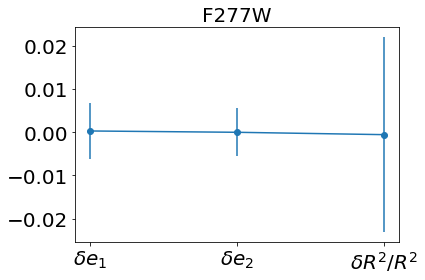

(array([1., 0., 0., 0., 4., 4., 8., 1., 1., 1.]),
 array([-0.06967818, -0.05785499, -0.0460318 , -0.0342086 , -0.02238541,
        -0.01056222,  0.00126097,  0.01308416,  0.02490735,  0.03673054,
         0.04855374]),
 <BarContainer object of 10 artists>)

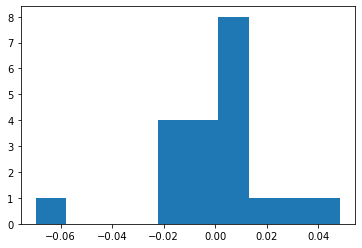

In [9]:
Fts=20
oshape=np.loadtxt(stamp_dirs+slicename+"_mcoshape.cat")
wshape=np.loadtxt(stamp_dirs+slicename+"_mcmshape.cat")
wwshape=np.loadtxt(stamp_dirs+slicename+"_mcwshape.cat")
indx=np.where(oshape[:,5]>40)
deshape=[]
for index in indx[0]:
    deshape.append([oshape[index][0]-wshape[index][0],oshape[index][1]-wshape[index][1],(oshape[index][2]-wshape[index][2])/oshape[index][2]])
deshape=np.array(deshape);print(deshape.shape)
dwshape=[]
for index in indx[0]:
    dwshape.append([oshape[index][0]-wwshape[index][0],oshape[index][1]-wwshape[index][1],(oshape[index][2]-wwshape[index][2])/oshape[index][2]])
dwshape=np.array(dwshape);print(dwshape.shape)
print(np.mean(deshape[:,0]),np.std(deshape[:,0]))
print(np.mean(deshape[:,1]),np.std(deshape[:,1]))
print(np.mean(deshape[:,2]),np.median(deshape[:,2]),np.std(deshape[:,2]))
plt.errorbar([1,2,3],[np.mean(deshape[:,0]),np.mean(deshape[:,1]),np.mean(deshape[:,2])],
             yerr=[np.std(deshape[:,0]),np.std(deshape[:,1]),np.std(deshape[:,2])],marker='o')
#plt.errorbar([1,2,3],[np.mean(dwshape[:,0]),np.mean(dwshape[:,1]),np.mean(dwshape[:,2])],
#             yerr=[np.std(dwshape[:,0]),np.std(dwshape[:,1]),np.std(dwshape[:,2])],marker='o')
plt.xticks([1,2,3],['$\delta{e_1}$','$\delta{e_2}$','$\delta{R^2}/R^2$'],fontsize=Fts)
plt.yticks(fontsize=Fts)
#plt.legend(fontsize=Fts,loc='upper left')
plt.title(filte,fontsize=Fts)
plt.tight_layout()
plt.show()
#plt.savefig("/home/lnie/code/JWST/co277W.pdf")
plt.hist(deshape[:,2],bins=10)

(30, 3)
(30, 3)
0.0007091181960606378 0.010587654030946933
-0.0026992976012575527 0.007622566357277096
0.0012848594701967374 -0.009600674606984546 0.03108140909070467


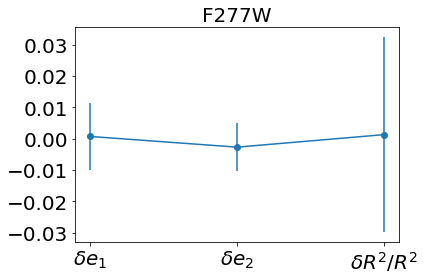

In [49]:
Fts=20
oshape=np.loadtxt(stamp_dirs+slicename+"_cooshape.cat")
wshape=np.loadtxt(stamp_dirs+slicename+"_comshape.cat")
wwshape=np.loadtxt(stamp_dirs+slicename+"_cowshape.cat")
indx=np.where(oshape[:,5]>40)
deshape=[]
for index in indx[0]:
    deshape.append([oshape[index][0]-wshape[index][0],oshape[index][1]-wshape[index][1],(oshape[index][2]-wshape[index][2])/oshape[index][2]])
deshape=np.array(deshape);print(deshape.shape)
dwshape=[]
for index in indx[0]:
    dwshape.append([oshape[index][0]-wwshape[index][0],oshape[index][1]-wwshape[index][1],(oshape[index][2]-wwshape[index][2])/oshape[index][2]])
dwshape=np.array(dwshape);print(dwshape.shape)
print(np.mean(deshape[:,0]),np.std(deshape[:,0]))
print(np.mean(deshape[:,1]),np.std(deshape[:,1]))
print(np.mean(deshape[:,2]),np.median(deshape[:,2]),np.std(deshape[:,2]))
plt.errorbar([1,2,3],[np.mean(deshape[:,0]),np.mean(deshape[:,1]),np.mean(deshape[:,2])],
             yerr=[np.std(deshape[:,0]),np.std(deshape[:,1]),np.std(deshape[:,2])],marker='o')
#plt.errorbar([1,2,3],[np.mean(dwshape[:,0]),np.mean(dwshape[:,1]),np.mean(dwshape[:,2])],
#             yerr=[np.std(dwshape[:,0]),np.std(dwshape[:,1]),np.std(dwshape[:,2])],marker='o')
plt.xticks([1,2,3],['$\delta{e_1}$','$\delta{e_2}$','$\delta{R^2}/R^2$'],fontsize=Fts)
plt.yticks(fontsize=Fts)
#plt.legend(fontsize=Fts,loc='upper left')
plt.title(filte,fontsize=Fts)
plt.tight_layout()
plt.savefig("/home/lnie/code/JWST/co277W.pdf")

In [12]:
ls /home/lnie/data/JWST_rev/NIRCam/F277W//catalogue/star_stamps/

/bin/bash: /home/lnie/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
F277Walong_it0_UPDC_rev4_mask.fits      F277Walong_it1_UPDC_rev4_mcmshape.cat
F277Walong_it0_UPDC_rev4_star.fits      F277Walong_it1_UPDC_rev4_mcoshape.cat
F277Walong_it1_UPDC_rev4_3mcmshape.cat  F277Walong_it1_UPDC_rev4_mcwshape.cat
F277Walong_it1_UPDC_rev4_3mcoshape.cat  F277Walong_it1_UPDC_rev4_mixchi.fits
F277Walong_it1_UPDC_rev4_3mcwshape.cat  F277Walong_it1_UPDC_rev4_mixresidu.fits
F277Walong_it1_UPDC_rev4_cmodel.fits    F277Walong_it1_UPDC_rev4_webchi.fits
F277Walong_it1_UPDC_rev4_comodel.fits   F277Walong_it1_UPDC_rev4_webresidu.fits
F277Walong_it1_UPDC_rev4_comodel1.fits  comodel.fits


In [138]:
48*0.7+89*0.3

60.3

(27, 3)
(27, 3)
0.0028367706873412258 0.00886029400657856
-0.0014383357259145815 0.005396533699621836
-0.0020488115171620846 0.004307602663918803 0.01722595328248761


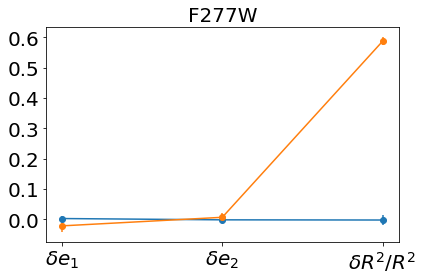

In [9]:
fn="/data/JWST_rev/coadd_img/rev4/parallel_field/F277Walong_it1_UPDC_rev4.fits"
catname="/home/lnie/data/JWST_rev/NIRCam/F277W//catalogue/star/F277Walong_it0_UPDC_rev4_star.cat"
stampname="/home/lnie/data/JWST_rev/NIRCam/F277W//catalogue/star_stamps/F277Walong_it0_UPDC_rev4_star.fits"
maskname="/home/lnie/data/JWST_rev/NIRCam/F277W//catalogue/star_stamps/F277Walong_it0_UPDC_rev4_mask.fits"
Cam="NIRCam/"
filte="F277W"
odirs="/data/SMACS0723_NIRCam_pipeline1.8.1/"+filte+'/'
dirs="/home/lnie/data/JWST_rev/"+Cam+filte+'/'
PCdirs="/home/lnie/data/PC/JWST/"+Cam+filte+'/'
stamp_dirs=dirs+"/catalogue/star_stamps/"
tmpname=fn.split("/");l0=len(tmpname);l1=len(tmpname[l0-1]);slicename=tmpname[l0-1][0:l1-len(".fits")]  
Fts=20
oshape=np.loadtxt(stamp_dirs+slicename+"_3mcoshape.cat")
wshape=np.loadtxt(stamp_dirs+slicename+"_3mcmshape.cat")
wwshape=np.loadtxt(stamp_dirs+slicename+"_3mcwshape.cat")
indx=np.where(oshape[:,5]>100)
deshape=[]
for index in indx[0]:
    deshape.append([oshape[index][0]-wshape[index][0],oshape[index][1]-wshape[index][1],(oshape[index][2]-wshape[index][2])/oshape[index][2]])
deshape=np.array(deshape);print(deshape.shape)
dwshape=[]
for index in indx[0]:
    dwshape.append([oshape[index][0]-wwshape[index][0],oshape[index][1]-wwshape[index][1],(oshape[index][2]-wwshape[index][2])/oshape[index][2]])
dwshape=np.array(dwshape);print(dwshape.shape)
print(np.mean(deshape[:,0]),np.std(deshape[:,0]))
print(np.mean(deshape[:,1]),np.std(deshape[:,1]))
print(np.mean(deshape[:,2]),np.median(deshape[:,2]),np.std(deshape[:,2]))
plt.errorbar([1,2,3],[np.mean(deshape[:,0]),np.mean(deshape[:,1]),np.mean(deshape[:,2])],
             yerr=[np.std(deshape[:,0]),np.std(deshape[:,1]),np.std(deshape[:,2])],marker='o')
plt.errorbar([1,2,3],[np.mean(dwshape[:,0]),np.mean(dwshape[:,1]),np.mean(dwshape[:,2])],
             yerr=[np.std(dwshape[:,0]),np.std(dwshape[:,1]),np.std(dwshape[:,2])],marker='o')
plt.xticks([1,2,3],['$\delta{e_1}$','$\delta{e_2}$','$\delta{R^2}/R^2$'],fontsize=Fts)
plt.yticks(fontsize=Fts)
#plt.legend(fontsize=Fts,loc='upper left')
plt.title(filte,fontsize=Fts)
plt.tight_layout()
#plt.savefig("/home/lnie/code/JWST/co277W.pdf")

In [41]:
#for F277W parallel field 
#add PCA part
fn="/data/JWST_rev/coadd_img/rev4/parallel_field/F277Walong_it1_UPDC_rev4.fits"
catname="/home/lnie/data/JWST_rev/NIRCam/F277W//catalogue/star/F277Walong_it0_UPDC_rev4_star.cat"
stampname="/home/lnie/data/JWST_rev/NIRCam/F277W//catalogue/star_stamps/F277Walong_it0_UPDC_rev4_star.fits"
maskname="/home/lnie/data/JWST_rev/NIRCam/F277W//catalogue/star_stamps/F277Walong_it0_UPDC_rev4_mask.fits"
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import ctypes
import webbpsf
import os
from scipy.stats import sigmaclip
from astropy.stats import SigmaClip
from astropy.wcs import WCS

from psf_fit import star_shape,write_fits,get_filename,\
web_psf_fit,web_psf_rec,int2cent,model2pos,wgtmap,gaus_estimate\
,write_mult_fits,polyfit2d
from C_tools_lib import centriod_psf
from mcmcs import coeff2psf,interp_cubic

def size(image,center,sigma):
    '''
    size(image,center,sigma)
    center[0]=cx;center[1]=cy
    '''
    nx=image.shape[0];ny=image.shape[1]
    #print("nx=%d,ny=%d"%(nx,ny))
    W=0;R11=0;R22=0;R12=0;R2=0.;k=0;
    nh=(np.min([nx,ny])*0.5)**2
    #print("nh=%d,cx=%f,cy=%f"%(nh,center[0],center[1]))
    scale=0.5/(sigma**2)
    for i in range(nx):
        for j in range(ny):
            x=i-center[0];y=j-center[1]
            r2=x**2+y**2;weight=np.exp(-r2*scale)
            if r2<nh:
                W=W+image[i][j]*weight
                R11=R11+x*x*image[i][j]*weight
                R22=R22+y*y*image[i][j]*weight
                R12=R12+x*y*image[i][j]*weight
                #if k<10 :print(image[i][j],weight,sigma)
                #k=k+1;
    R11=R11/W;R22=R22/W;R12=R12/W
    #print("message:w11=%f,w12=%f,w22=%f,w=%f"%(R11,R12,R22,W))
    e1=(R11-R22)/(R11+R22)
    e2=(2.*R12)/(R11+R22)
    #print("message")
    R2=R11+R22
    #print(e1,e2,R2)
    if R2<=0 : R2=0.001
    if R2<=0 or np.fabs(e1)>=1. or np.fabs(e2)>=1.:
        #raise Exception("R2<=0\n")
        print("R2<=0\n");
        return(e1,e2,R2)
    else:
        return(e1,e2,R2)

def S2N(image,gain=1):
    Ng1=image.shape[0]
    Ng2=image.shape[1]
    weight=np.zeros(image.shape,dtype='float')
    mean,sigma=gaus_estimate(image)
    #print("method=%f,sigma=%f"%(mean,sigma))
    for i in range(Ng1):
        for j in range(Ng2):
            detx=sigma*sigma*gain*gain
            dety=gain*np.fabs(image[i][j])
            if dety<detx : error=sigma
            else : error=np.sqrt(dety+detx)/gain
            #weight[i][j]=1./(error**2)
            weight[i][j]=error
    snr=np.sum(image)/np.sqrt(np.sum(weight**2))
    return(snr)

nrca_short_detectors = ['NRCA1', 'NRCA2', 'NRCA3', 'NRCA4', 'NRCB1', 'NRCB2', 'NRCB3', 'NRCB4']
nrca_long_detectors = ['NRCA5', 'NRCB5']
F090W_fname="jw02736001001_02101_"
F150W_fname="jw02736001001_02103_"
F200W_fname="jw02736001001_02105_"
F277W_fname="jw02736001001_02101_"
F356W_fname="jw02736001001_02103_"
F444W_fname="jw02736001001_02105_"
sdetect=["nrca1","nrca2","nrca3","nrca4","nrcb1","nrcb2","nrcb3","nrcb4"]
ldetect=["nrcalong","nrcblong"]
ldetect=["nrcalong"]
detector=dict({"nrca1":"nrca1","nrca2":"nrca2","nrca3":"nrca3","nrca4":"nrca4",
               "nrcb1":"nrcb1","nrcb2":"nrcb2","nrcb3":"nrcb3","nrcb4":"nrcb4",
               "nrcalong":"nrca5","nrcblong":"nrcb5"})
filte_name=dict({"F090W":"jw02736001001_02101_","F150W":"jw02736001001_02103_",
                "F200W":"jw02736001001_02105_","F277W":"jw02736001001_02101_",
                "F356W":"jw02736001001_02103_","F444W":"jw02736001001_02105_"})
f2detpath=dict({"F090W":sdetect,"F150W":sdetect,"F200W":sdetect,
                "F277W":ldetect,"F356W":ldetect,"F444W":ldetect})
gains=dict({"nrca1":"2.08","nrca2":"2.02","nrca3":"2.17","nrca4":"2.02",
            "nrcb1":"2.01","nrcb2":"2.14","nrcb3":"1.94","nrcb4":"2.03",
            "nrcalong":"1.84","nrcblong":"1.80"})




osam=2
npc=10

Cam="NIRCam/"
filte="F277W"
odirs="/data/SMACS0723_NIRCam_pipeline1.8.1/"+filte+'/'
dirs="/home/lnie/data/JWST_rev/"+Cam+filte+'/'
PCdirs="/home/lnie/data/PC/JWST/"+Cam+filte+'/'
stamp_dirs=dirs+"/catalogue/star_stamps/"
TNg=80
ikk=0
Nim=5
cent=np.zeros(2,dtype='float')
hdu0=fits.open(fn)
cat=np.loadtxt(catname)
readstar=fits.open(stampname)[0].data
mask=fits.open(maskname)[0].data
Nobj=readstar.shape[0];Ng0=readstar.shape[1]
shapes=np.zeros((Nobj,2),dtype='float')
XPOSURE=hdu0['SCI'].header['XPOSURE']
PHOTMJSR=hdu0['SCI'].header['PHOTMJSR']
readstar*=(PHOTMJSR*XPOSURE)
#clear the candidates
for ic in range(Nobj):
    rx=cat[ic][1]+0.5;ry=cat[ic][2]+0.5
    cent[0],cent[1],sigma=centriod_psf(readstar[ic])
    oe1,oe2,or2=size(readstar[ic],cent,3.);
    mage=(oe1**2+oe2**2)**0.5
    shapes[ic][0]=mage;shapes[ic][1]=or2
cleane,low,high=sigmaclip(shapes[:,0],3.,3.)
cleanr,low,high=sigmaclip(shapes[:,1],3.,3.)
print("clean Nobj=",cleane.shape[0])
spos=np.zeros((cleane.shape[0],2),dtype='float')
instar=np.zeros((cleane.shape[0],Ng0,Ng0),dtype='float')
wgt=np.zeros(instar.shape,dtype='float');print(instar.shape,wgt.shape)
k=0
for ic in range(Nobj):
    snrs=S2N(readstar[ic],gain=float(gains[detect]))
    if k <cleane.shape[0] and shapes[ic][0]==cleane[k] and snrs>40:
        spos[k][0]=cat[ic][1];spos[k][1]=cat[ic][2]
        instar[k]=readstar[ic].T
        wgt[k]=mask[ic].T
        k+=1
Nobj=k;print("clean Nobj=",Nobj)




tmpname=fn.split("/");l0=len(tmpname);l1=len(tmpname[l0-1]);slicename=tmpname[l0-1][0:l1-len(".fits")]  
print(fn)
if "blong" in fn : detect="nrcblong"
if "along" in fn : detect="nrcalong"


Ng0=instar.shape[1]
Nobj=instar.shape[0]
tmp=np.zeros((1,Ng0*Ng0),dtype='float')
pcastar=np.zeros((0,Ng0*Ng0),dtype='float')
for star in instar:
    star/=np.sum(instar)
meanstar=np.zeros(instar[0].shape,dtype='float')
for i in range(instar.shape[0]):
    for j in range(instar.shape[1]):
        meanstar[i][j]=np.mean(instar[:,i,j])
for star in instar:
    star-=meanstar
    tmp[0]=star.ravel()
    pcastar=np.concatenate([pcastar,tmp])
pcastar=pcastar.T
PC,sigma,v=np.linalg.svd(pcastar)
coeff=np.ones((Nobj,npc,2),dtype='float')
for i in range(npc):
    coeff[:,i,0]=sigma[i]*v.T[:,i]
PCs=(PC[:,0:npc].T).reshape(npc,Ng,Ng)    
    
getNobj=Nobj    
polyorder=2
if getNobj>10:polyorder=3
if getNobj>15:polyorder=4
if getNobj>21:polyorder=5
rPSF=coeff2psf(pos,coeff,PCs,pos,degrees=polyorder);print("rPSF",rPSF.shape)
icoeff=polyfit2d(pos,webcoeff[:,0],webcoeff[:,1],pos,3)
eNg=rPSF.shape[1]
Ng=int(eNg/osam)
sNg=30;dpix=int((slecstar.shape[1]-sNg)/2);cut=int(((Ng0+Nim)*osam-eNg)/2)
mix_mod=np.zeros(rPSF.shape,dtype='float')
rrPSF=np.zeros((getNobj,sNg,sNg),dtype='float')
chi1=np.zeros((getNobj,sNg,sNg))
chi2=np.zeros((getNobj,sNg,sNg))
residu1=np.zeros((getNobj,sNg,sNg))
residu2=np.zeros((getNobj,sNg,sNg))
fp=open(stamp_dirs+slicename+"_cooshape.cat","w")
fpw=open(stamp_dirs+slicename+"_cowshape.cat","w")
fpm=open(stamp_dirs+slicename+"_comshape.cat","w")
for ic in range(getNobj):
    mean,sigma=gaus_estimate(slecstar[ic]);
    print(ic,mean,sigma)
    #mean,sigma=gaus_estimate(rPSF[ic]);rPSF[ic]-=mean
    slecstar[ic]-=mean
    #slecstar[ic]*=wgt[ic]
    snrs=S2N(slecstar[ic],gain=1.84)
    slecstar[ic]/=np.sum(slecstar[ic])
    tmp=wgtmap(slecstar[ic])
    tmp_img=slecstar[ic][dpix:dpix+sNg,dpix:dpix+sNg]
    tmp_wgt=wgt[ic][dpix:dpix+sNg,dpix:dpix+sNg]#mask
    tmp_img*=tmp_wgt
    #tmp_img/=np.sum(tmp_img) #normalise
    error_map=tmp[dpix:dpix+sNg,dpix:dpix+sNg];#error_map/=sums  #weight map
    tmp_wmap=1./(error_map*error_map)*tmp_wgt;
    cent[0],cent[1],sigma=centriod_psf(tmp_img);
    print(cent[0],cent[1])
    dx=cent[0]-(sNg/2.+0.5)+1;dy=cent[1]-(sNg/2.+0.5)+1
    rrPSF[ic]=interp_cubic(rPSF[ic],sNg,dy,dx,osam=2)
    tmp_mod=interp_cubic(comodel[ic],sNg,dy,dx,osam=1)
    #print("sum:", np.sum(rrPSF[ic]))
    #mean,sigma=gaus_estimate(rrPSF[ic]);rrPSF[ic]-=mean
    rrPSF[ic]=rrPSF[ic].T;
    tmp_mod*=tmp_wgt;
    frac=(1.-np.sum(comodel[ic,cut:cut+eNg,cut:cut+eNg]))
    #rPSF=rPSF/np.sum(rPSF)*frac
    #tmp_mod/=np.sum(tmp_mod)
    for i in range(eNg):
        for j in range(eNg):
            mix_mod[ic][i][j]=0
            mix_mod[ic][i][j]=(rPSF[ic][i][j]+comodel[ic][i+cut][j+cut]*icoeff[ic])#mixture model
            if mix_mod[ic][i][j]<0 : mix_mod[ic][i][j]=0
    for i in range(eNg):
        for j in range(eNg):
            if mix_mod[ic][i][j]==0 and i-1>0 and i+1<eNg and j-1>0 and j+1<eNg:
                mix_mod[ic][i][j]=(mix_mod[ic][i-1][j-1]+mix_mod[ic][i-1][j]+mix_mod[ic][i-1][j+1]+
                                   mix_mod[ic][i][j-1]+mix_mod[ic][i][j+1]+
                                   mix_mod[ic][i+1][j-1]+mix_mod[ic][i+1][j]+mix_mod[ic][i+1][j+1])/8.
    tmp_mix_mod=interp_cubic(mix_mod[ic],sNg,dy,dx,osam)
    tmp_mix_mod*=tmp_wgt;
    print(np.sum(tmp_img),np.sum(tmp_mix_mod))
    #mean,sigma=gaus_estimate(tmp_mix_mod);tmp_mix_mod-=mean
    tmp_img/=np.sum(tmp_img);tmp_mod/=np.sum(tmp_mod);tmp_mix_mod/=np.sum(tmp_mix_mod)
    residu1[ic]=(tmp_img-tmp_mod).T
    residu2[ic]=(tmp_img-tmp_mix_mod).T
    oe1,oe2,or2=size(tmp_img,cent,3.);
    we1,we2,wr2=size(tmp_mod,cent,3.);
    me1,me2,mr2=size(tmp_mix_mod,cent,3.);
    print(oe1,oe2,or2)
    print(me1,me2,mr2)
    fpw.writelines(str(we1)+'\t'+str(we2)+'\t'+str(wr2)+'\t'+str(spos[ic][0])+'\t'+str(spos[ic][1])+'\t'+str(snrs)+'\n')
    fp.writelines(str(oe1)+'\t'+str(oe2)+'\t'+str(or2)+'\t'+str(spos[ic][0])+'\t'+str(spos[ic][1])+'\t'+str(snrs)+'\n')
    fpm.writelines(str(me1)+'\t'+str(me2)+'\t'+str(mr2)+'\t'+str(spos[ic][0])+'\t'+str(spos[ic][1])+'\t'+str(snrs)+'\n')
    chi1[ic]=residu1[ic]*residu1[ic]*tmp_wmap
    chi2[ic]=residu2[ic]*residu2[ic]*tmp_wmap
#write_fits("fits/rPSF.fits",rrPSF)
fp.close();fpw.close();fpm.close()
write_fits(stamp_dirs+slicename+"_cowebchi.fits",chi1)
write_fits(stamp_dirs+slicename+"_comixchi.fits",chi2)
write_fits(stamp_dirs+slicename+"_cowebresidu.fits",residu1)
write_fits(stamp_dirs+slicename+"_comixresidu.fits",residu2)  
#write_fits("fits/ostars.fits",instar)
oshape=np.loadtxt(stamp_dirs+slicename+"_cooshape.cat")
wshape=np.loadtxt(stamp_dirs+slicename+"_comshape.cat")
de1=oshape[:,0]-wshape[:,0];de2=oshape[:,1]-wshape[:,1];dr=(oshape[:,2]**0.5-wshape[:,2]**0.5)
print(np.mean(oshape[:,0]),np.mean(oshape[:,1]),np.mean(oshape[:,2]))
print(np.mean(de1),np.std(de1),np.mean(de2),np.std(de2),np.median(dr),np.std(dr),
      np.mean((oshape[:,2]-wshape[:,2])/oshape[:,2]))

   



/bin/bash: /home/lnie/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
CSST_MCI_C1_EXDF_20230512091940_20230512092440_20100000001_07_L1_VER_flg.fits
CSST_MCI_C1_EXDF_20230512091940_20230512092440_20100000001_07_L1_VER_img.fits
CSST_MCI_C1_EXDF_20230512091940_20230512092440_20100000001_07_L1_VER_img.head
CSST_MCI_C1_EXDF_20230512091940_20230512092440_20100000001_07_L1_VER_wht.fits
CSST_MCI_C1_EXDF_20230516023339_20230516023839_20100000001_07_L1_VER_flg.fits
CSST_MCI_C1_EXDF_20230516023339_20230516023839_20100000001_07_L1_VER_img.fits
CSST_MCI_C1_EXDF_20230516023339_20230516023839_20100000001_07_L1_VER_img.head
CSST_MCI_C1_EXDF_20230516023339_20230516023839_20100000001_07_L1_VER_img_fcr.fits
CSST_MCI_C1_EXDF_20230516023339_20230516023839_20100000001_07_L1_VER_wht.fits
CSST_MCI_C1_EXDF_20230518135939_20230518140439_20100000001_07_L1_VER_flg.fits
CSST_MCI_C1_EXDF_20230518135939_20230518140439_20100000001_07_L1_VER_img.fits
CSST_MCI_C1_EXDF_2023051813593

In [289]:
hdu=fits.open("/home/lnie/data/JWST_rev/NIRCam/F090W/nrcb4/catalogue/star_stamps/jw02736001001_02101_00001_nrcb4_cal_pv181_rev4_star.fits")
hdu.info()

Filename: /home/lnie/data/JWST_rev/NIRCam/F090W/nrcb4/catalogue/star_stamps/jw02736001001_02101_00001_nrcb4_cal_pv181_rev4_star.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      10   (80, 80, 13)   float32   


In [34]:
hdu=fits.open("/data/JWST_rev/coadd_img/rev4/parallel_field/F277Walong_it0_UPDC_rev4.fits")
hdu.info()

Filename: /data/JWST_rev/coadd_img/rev4/parallel_field/F277Walong_it0_UPDC_rev4.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (4772, 4772)   float32   


In [9]:
nrc.detector_position=(ipx,ipy)
psf = nrc.calc_psf(fov_pixels=Ng0+Nim,oversample=2)

ValueError: The maximum allowed detector pixel coordinate value is 2047

In [10]:
def uv2xy(u, v, header):
    """
    Covert u & v to (x, y)

    :param u: flat, array
    :param v: flat, array
    :param header:
    :return: x, y , the position in the data array in pixels
    """
    import numpy as np
    u_ref,v_ref = 0,0
    delt_u,delt_v = u - u_ref, v- v_ref
    x = header["CRPIX1"] + (header["CD2_2"] * delt_u - header["CD1_2"] * delt_v) / (
            header["CD2_2"] * header["CD1_1"] - header["CD1_2"] * header["CD2_1"])
    y = header["CRPIX2"] + (header["CD2_1"] * delt_u - header["CD1_1"] * delt_v) / (
            header["CD1_2"] * header["CD2_1"] - header["CD2_2"] * header["CD1_1"])

    return x, y

'NRCA5'